
<span style="color:green"><h1>UCLA, Fall 2024 </span> <span style="color:yellow"> ****</h1></span>
<span style="color:blue"><h2>Professor Abeer Alwan, alwan@ee.ucla.edu</span> <span style="color:yellow"> ****</h2></span>
<span style="color:blue"><h3>Dept. of Electrical Engineering EE214A: Digital Speech Processing</span> <span style="color:yellow"> ****</span>



##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.github.io/coraal) with speakers each belonging to one of six different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), 5) Valdosta, GA (VLD) or 6) Detroit, MI (DTA)

The project files can be downloaded from [this link](https://ucla.box.com/s/mohh4fnmgj3vekui8i8n28i02odleaop)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Store a copy of the project files in your google drive.

Make sure that the 'project_data' folder is stored in the top level of your google drive. Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below.

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [491]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    print ("*" * 62)
    print ("*" * 10 , "<<< Skipping This Cell from Execution >>>","*" * 10)
    print ("*" * 62)
    return

# <span style="color:orange">1. Required Common Imports - Packages/Modules/Libraries <span> 

## <span style="color:blue"> 1.a - Required Common Installation of Packages <span>

In [492]:
# %%skip

%pip install torchaudio
%pip install --upgrade pip
%pip install librosa
%pip install xgboost
%pip install tqdm
%pip install panda
%pip install shap
%pip install matplotlib
%pip install opensmile
%pip install ipywidgets
%pip install speechbrain
%pip install spafe
%pip install seaborn
%pip install transformers
%pip install google
%pip install noisereduce


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


## <span style="color:blue">1.b. - Required Common imports<span>

In [493]:
# %%skip

import os  # Standard library for interacting with the operating system
import sys  # Standard library for system-specific parameters and functions
import torch  # PyTorch: A deep learning framework for building and training neural networks
import zipfile  # Standard library for working with ZIP archives
from IPython.display import Audio  # IPython module for displaying audio in notebooks
# from google.colab import userdata  # Google Colab module for user data handling
# from google.colab import drive  # Google Colab module for Google Drive integration
import librosa  # Library for audio and music analysis
import torchaudio  # PyTorch's audio library for audio processing
import numpy as np  # Library for numerical operations and array manipulations
from glob import glob  # Standard library for finding all file paths matching a pattern
from tqdm import tqdm  # Library for creating progress bars
import xgboost  # Library for gradient boosting decision trees
import shap  # SHAP (SHapley Additive exPlanations): Library for model interpretability
import pandas as pd  # Library for data manipulation and analysis
from speechbrain.inference.speaker import EncoderClassifier  # SpeechBrain: Library for speaker recognition and other speech processing tasks
from sklearn import metrics  # Scikit-learn: Library for machine learning and evaluation metrics
import matplotlib.pyplot as plt  # Matplotlib: Library for creating static, animated, and interactive visualizations
import re  # Standard library for regular expressions
import opensmile  # OpenSMILE: Feature extraction toolkit for audio signal processing

import torchaudio
import numpy as np
import librosa
import scipy.signal as sps
import spafe.features.mfcc as mfcc
import spafe.features.lfcc as lfcc
import spafe.features.gfcc as gfcc  # Gammatone Filterbank Cepstral Coefficients (GTCC equivalent)
import spafe.features.pncc as pncc
import torch
from speechbrain.pretrained import EncoderClassifier
import opensmile
from sklearn.preprocessing import StandardScaler
from scipy.signal import lfilter
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.fftpack import dct
import soundfile as sf
import noisereduce as nr
from scipy.fftpack import dct
import librosa 
import librosa.display 
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct

import subprocess

# <span style="color:orange"> 2. Environment Setup <span>

### <span style="color:blue">2.a. - Print Environemnt Information<span>

In [494]:
# %%skip

import sys

def is_colab():
  return 'google.colab' in sys.modules

if is_colab():
  print("Running in Google Colab")
  !python --version
else:
  print("Not running in Google Colab")
  %pip --version
  !python3 --version

Not running in Google Colab
pip 24.3.1 from /Users/parthakundu/.pyenv/versions/3.10.12/lib/python3.10/site-packages/pip (python 3.10)
Note: you may need to restart the kernel to use updated packages.
Python 3.10.12


### <span style="color:blue">2.b. - Checking GPU is avaialble or not<span>

In [495]:
# %%skip

import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Running on GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Running on CPU.")

# Example code to run on the selected device
# Create a tensor and move it to the selected device
x = torch.tensor([1.0, 2.0, 3.0])
x = x.to(device)

# Print the tensor and the device it is on
print(f"Tensor: {x}")
print(f"Device: {x.device}")


GPU is not available. Running on CPU.
Tensor: tensor([1., 2., 3.])
Device: cpu


### <span style="color:yellow"> **** </span><span style="color:blue">2.c. - Setting up environment based on Colab Vs Laptop </span> <span style="color:yellow"> ****</span>


In [496]:
# %%skip

if is_colab():
  print("*******  Running in Google Colab Environment *******")
  
  from google.colab import userdata
  gh_pat = userdata.get('gh_pat')
  gh_username = userdata.get('gh_username')


  # We have to 'mount' google drive to this notebook. This will allow us to access files from google drive here.
  # You will be asked permission to grant access to your drive. Click 'Connect to Google Drive' when prompted and select the appropriate google account. Click on Continue untill window closes.

  from google.colab import drive
  drive.mount('/content/drive')

  import sys, os
  parent_dir = os.path.dirname(os.path.realpath('drive/MyDrive/ece_m214/'))
  print (parent_dir)

  # To get one directory up from the current file
  project_dir = os.path.abspath(os.path.join(parent_dir, 'ece_m214/final_project'))

  sys.path.insert(0,project_dir)

  print ('Parent Directory Path:', parent_dir)
  print ('Project Path:', project_dir)

else:

  print("*********  Running in Non - Google Colab Environment *********")
  
  import sys, os

  parent_dir = os.path.dirname(os.path.realpath('/Users/parthakundu/GitHub/my_ucla_grad_projects/'))
  print (parent_dir)

  # To get one directory up from the current file
  project_dir = os.path.abspath(os.path.join(parent_dir, "./my_ucla_grad_projects/ucla-ece-m214a-project-sri/"))

  sys.path.insert(0,project_dir)

  print ('Parent Directory Path:', parent_dir)
  print ('Project Path:', project_dir)


*********  Running in Non - Google Colab Environment *********
/Users/parthakundu/GitHub
Parent Directory Path: /Users/parthakundu/GitHub
Project Path: /Users/parthakundu/GitHub/my_ucla_grad_projects/ucla-ece-m214a-project-sri


In [497]:
# %%skip
import os

folder1_path = project_dir + "/dataFrame"
folder2_path = project_dir + "/images"
folder3_path = project_dir + "/project_data"
folder4_path = project_dir + "/zip_files"

os.makedirs(folder1_path, exist_ok=True)
os.makedirs(folder2_path, exist_ok=True)
os.makedirs(folder3_path, exist_ok=True)
os.makedirs(folder4_path, exist_ok=True)

In [559]:
%%skip

import subprocess

# List of commands to execute
commands = [
    "pip show torchaudio",
    "pip show librosa",
    "pip show xgboost",
    "pip show tqdm",
    "pip show pandas",
    "pip show shap",
    "pip show matplotlib",
    "pip show opensmile",
    "pip show ipywidgets",
    "pip show speechbrain",
    "pip show spafe",
    "pip show seaborn",
    "pip show transformers"
]

# Open a file to write the output
with open(project_dir + '/package_info.txt', 'w') as file:
    for command in commands:
        # Execute the command
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        # Capture the output and errors
        stdout, stderr = process.communicate()
        # Write the command to the file
        file.write(f"Command: {command}\n")
        # Write the output to the file
        file.write(stdout.decode('utf-8'))
        # Write any errors to the file
        if stderr:
            file.write(stderr.decode('utf-8'))
        file.write("\n" + "="*40 + "\n")

print(f"Package information saved to {project_dir}\package_info.txt")


Package information saved to /Users/parthakundu/GitHub/my_ucla_grad_projects/ucla-ece-m214a-project-sri\package_info.txt


### <span style="color:red"> ***** </span><span style="color:orange">2.d.1 - Loading Initial/Given Dataset</span> <span style="color:green"> ***** </span>

In [499]:
%%skip

#  Uncomment following line of codes and execute if you need unzip the provided package with dataset for the project.

import zipfile

with zipfile.ZipFile(parent_dir + '/ece_m214/final_project/F24 ECE M214A Project.zip', 'r') as zip_ref:
    zip_ref.extractall(parent_dir + '/ece_m214/final_project/')

To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

### <span style="color:red"> ***** </span><span style="color:orange">2.d.2 - Getting familiar with the data</span> <span style="color:green"> ***** </span>


Let's take a moment to understand the data.  The original CORAAL dataset consists of speakersfrom one of seven cities split into 8 components.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 5 seconds in length. Those segments are numbered with the appending tag _{seg_number} for each segment.

You can also try listening to any segment like this:

In [500]:
%%skip
from IPython.display import Audio

sr = 44100

Audio(filename= project_dir + "/project_data/train/DCB_se1_ag2_m_01_1_11.wav", rate=sr)

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of noise:

In [501]:
%%skip
sr = 44100

Audio(filename= project_dir + "/project_data/test_clean/ROC_se0_ag2_f_01_1_396.wav", rate=sr)

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


In [502]:
%%skip
sr = 44100

Audio(filename= project_dir + "/project_data/test_noisy/VLD_se0_ag4_m_02_1_64.wav", rate=sr)

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


## <span style="color:red"> ***** </span><span style="color:orange">3. Feature Extraction Process </span> <span style="color:green"> ***** </span>

### <span style="color:red"> ***** </span><span style="color:orange">3.a. - Feature Extraction Methods </span> <span style="color:green"> ***** </span>

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [503]:
import torchaudio
import numpy as np
import librosa
import scipy.signal as sps
import spafe.features.mfcc as mfcc
import spafe.features.lfcc as lfcc
import spafe.features.gfcc as gfcc  # Gammatone Filterbank Cepstral Coefficients (GTCC equivalent)
import spafe.features.pncc as pncc
import torch
from speechbrain.pretrained import EncoderClassifier
import opensmile
from sklearn.preprocessing import StandardScaler
from scipy.signal import lfilter
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.fftpack import dct
import soundfile as sf
import noisereduce as nr
from scipy.fftpack import dct
import librosa 
import librosa.display 
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct

# Load the pre-trained x-vector model from SpeechBrain
classifier_xvector = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="tmpdir")

# Load pre-trained Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Initialize OpenSMILE
smile1 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals
)

smile2 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

smile3 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

def whitening_filter(signal):
    """Apply whitening filter to the signal."""
    mean = np.mean(signal)
    std_dev = np.std(signal)
    whitened_signal = (signal - mean) / std_dev
    return whitened_signal

def spectral_gating(signal, threshold=0.1):
    """Apply spectral gating filter to the signal."""
    stft = librosa.stft(signal)
    magnitude, phase = librosa.magphase(stft)
    spectral_gate = magnitude > (threshold * np.max(magnitude))
    gated_stft = stft * spectral_gate
    gated_signal = librosa.istft(gated_stft)
    return gated_signal

# Function to check if the LPC features are valid
def is_valid_features(features):
    if np.isnan(features).any() or np.isinf(features).any():
        return False
    return True

# Function to normalize audio signal
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def extract_feature_advance(audio_file, n_feature=13, preprocess='librosa', feature_method='mfcc',whitening=False, spectral_gating=False, test_data_type='clean', order=26,winlen=0.025, winstep=0.01, n_mels=40):
    """
    Function to extract features from a single audio file given its path.
    :param audio_file: Path to the audio file.
    :param n_mfcc: Number of MFCC features to extract.
    :param preprocess: Preprocessing method ('scipy' or 'librosa'), default is 'librosa'.
    :param feature_method: Feature extraction method ('mfcc', 'gtcc', 'pncc', 'lfcc', 'xvector', 'ivector', 'opensmile', or 'plp'), default is 'mfcc'.
    :param whitening: Apply whitening filter. 
    :param spectral_gating: Apply spectral gating filter.
    :return: Extracted feature array.
    """
    
    # Load audio file
    audio, fs = torchaudio.load(audio_file)
    audio = audio.numpy().reshape(-1)
    
    if preprocess == 'scipy':
        # Preprocessing using scipy
        audio = sps.resample(audio, int(len(audio) * 16000 / fs))
        fs = 16000
    elif preprocess == 'librosa':
        # Preprocessing using librosa
        audio = librosa.resample(audio, orig_sr=fs, target_sr=16000)
        fs = 16000

    if whitening:
        audio = whitening_filter(audio)
    
    if spectral_gating:
        audio = spectral_gating(audio)
    
    # Feature extraction

    if feature_method == 'mel':
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=fs)
        features = mel_spectrogram
    elif feature_method == 'log_mel':
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=fs)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        features = log_mel_spectrogram        
    elif feature_method == 'mfcc':
        # Extract MFCC features
        features = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_feature)
    elif feature_method == 'lfcc':
        # Extract LFCC features
        features = lfcc.lfcc(audio, fs=fs, num_ceps=n_feature)
    elif feature_method == 'gtcc':
        # Extract GTCC (using GFCC) features
        features = gfcc.gfcc(audio, fs=fs, num_ceps=n_feature)
    elif feature_method == 'pncc':
        # Extract PNCC (Power-Normalized Cepstral Coefficients) features
        features = pncc.pncc(audio, fs=fs, num_ceps=n_feature)

        # <<<<< Below code need to be removed >>>>>> 
        # # Ensure audio is mono by taking only one channel
        # if len(audio.shape) > 1 and audio.shape[0] > 1:
        #     audio = np.mean(audio, axis=0, keepdims=True)

        # audio = audio.flatten()  # Directly flatten the NumPy array

        # # Calculate n_fft based on audio length
        # n_fft = 2**int(np.ceil(np.log2(len(audio))))

        # # Pre-emphasis
        # preemph_signal = librosa.effects.preemphasis(audio)

        # # STFT
        # hop_length = int(fs * winstep)
        # win_length = int(fs * winlen)
        # S = librosa.stft(preemph_signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
        # power_spectrum = np.abs(S)**2

        # # Mel filterbank
        # mel_filters = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels)
        # filtered_spectrum = np.dot(mel_filters, power_spectrum)

        # # # Medium-time power analysis (mean over time)
        # # medium_time_power = np.mean(filtered_spectrum, axis=1, keepdims=True)

        # # Asymmetric noise suppression
        # lambda_a, lambda_b = 0.999, 0.5
        # Q = np.zeros_like(filtered_spectrum)

        # # Vectorized noise suppression using cumulative maximum
        # Q[:, 0] = filtered_spectrum[:, 0]
        # for t in range(1, filtered_spectrum.shape[1]):
        #     Q[:, t] = np.maximum(filtered_spectrum[:, t], lambda_a * Q[:, t-1])

        # Q_floor = np.zeros_like(Q)

        # # Vectorized floor calculation
        # for t in range(Q.shape[1]):
        #     Q_floor[:, t] = np.minimum(Q[:, t], lambda_b * Q_floor[:, t-1] + (1 - lambda_b) * Q[:, t])

        # # Power law nonlinearity
        # power_law = 1 / 15
        # P = (Q - Q_floor) ** power_law

        # # Mean power normalization
        # P_norm = P / np.mean(P, axis=1, keepdims=True)

        # # DCT
        # pncc_features = dct(P_norm, type=2, axis=0, norm='ortho')[:n_feature]
        # features = pncc_features.T

        # <<<<   Until Here >>>> 

    elif feature_method == 'xvector':
        # Extract features using x-vector
        # Compute speaker embedding for the segment
        signal = torch.tensor(audio).unsqueeze(0)  # Add batch dimension
        embedding = classifier_xvector.encode_batch(signal)
        features = embedding.detach().numpy().squeeze()

        # Now you have a single mean speaker embedding
        # print(embedding.shape)
        # raise NotImplementedError("i-vector extraction is not implemented in this example.")
    elif feature_method == 'ivector':
        # Placeholder for i-vector extraction logic
        # i-vector extraction typically requires a trained model and sufficient setup, often done using Kaldi
        raise NotImplementedError("i-vector extraction is not implemented in this example.")
    elif feature_method == 'opensmile_ComParE_2016':
        # Extract features using OpenSMILE (ComParE_2016)
        features = smile1.process_signal(audio, fs).values.flatten()
    elif feature_method == 'opensmile_GeMAPSv01b':
        # Extract features using OpenSMILE (GeMAPSv01b)
        features = smile2.process_signal(audio, fs).values.flatten()
    elif feature_method == 'opensmile_eGeMAPSv02':
        # Extract features using OpenSMILE (eGeMAPSv02)
        features = smile3.process_signal(audio, fs).values.flatten()                
    elif feature_method == 'plp':
        # Extract PLP features
        if test_data_type == 'noisy':
            y_preemphasized = librosa.effects.preemphasis(y=audio)
            #reduced_noise = nr.reduce_noise(y_preemphasized,sr=sr)
            S = librosa.feature.melspectrogram(y=y_preemphasized, sr=fs)
        else:
            S = librosa.feature.melspectrogram(y=audio, sr=fs)

        log_S = librosa.power_to_db(S, ref=np.max)

        equal_loudness = librosa.core.A_weighting(librosa.fft_frequencies(sr=fs))
        log_S_eq = log_S + equal_loudness[:log_S.shape[0], np.newaxis]

        log_S_compressed = librosa.power_to_db(10**(log_S_eq / 20), ref=np.max)

        features = librosa.feature.mfcc(S=log_S_compressed, n_mfcc=n_feature)
        
    elif feature_method == 'lpc':
        # Extract features with additional checks and preprocessing
        if test_data_type == 'noisy':
            y_preemphasized = librosa.effects.preemphasis(y=audio)
            # y_preemphasized = normalize_audio(y_preemphasized)
            features = librosa.lpc(y_preemphasized, order=order)
        else:
            # audio = normalize_audio(audio)
            features = librosa.lpc(audio, order=order)

        # # Check if the features are valid
        # if not is_valid_features(features):
        #     # print("Invalid LPC features detected!")
        #     features = np.zeros(order + 1)  # Replace with appropriate default value

        # print("LPC Features:", features)

    elif feature_method == 'wav2vec2':

        waveform, sample_rate = torchaudio.load(audio_file)
        
        if sample_rate != 16000:
            waveform = resampled_waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
    
        input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values

        with torch.no_grad():
            outputs = model(input_values, output_hidden_states=True)
    
        # Extract the last hidden state
        last_hidden_state = outputs.hidden_states[-1].squeeze().numpy()
        
        # Compute mean of the last hidden state as a feature vector
        features = np.mean(last_hidden_state, axis=0)
    
    else:
        raise ValueError(f"Unsupported feature extraction method: {feature_method}")
    
    
    if feature_method in ['lpc']:
        # Calculate delta and delta-delta (optional)
        delta1 = features[:-1] - features[1:]
        delta2 = delta1[:-1] - delta1[1:]

        # Concatenate features with their deltas
        features = np.concatenate((features, delta1, delta2))
        
        # Average the features across the time axis
        feat_out = features
    
    elif feature_method not in [ 'pncc','wav2vec2', 'plp','xvector', 'opensmile_ComParE_2016', 'opensmile_GeMAPSv01b','opensmile_eGeMAPSv02' ]:
        # Calculate delta and delta-delta (optional)
        delta1 = features[:-1] - features[1:]
        delta2 = delta1[:-1] - delta1[1:]

        # Concatenate features with their deltas
        features = np.concatenate((features, delta1, delta2))
        
        # Average the features across the time axis
        feat_out = np.mean(features, axis=1)
    else:
        feat_out = features

    return feat_out

# # Example usage:
# audio_file = 'path/to/your/audio.wav'
# features = extract_feature_advance(audio_file, n_feature=13, preprocess='scipy', feature_method='xvector')
# print(features)


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
/Users/parthakundu/.pyenv/versions/3.10.12/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which 

In [504]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

### <span style="color:red"> ***** </span><span style="color:orange">3.b. - Load Dataset, Extract Features and Save the Extracted Feature in dataframe </span> <span style="color:green"> ***** </span>

Let us now call these functions to extract the features and labels from the train directory

### <span style="color:red"> ***** </span><span style="color:blue"><b>3.b.1. - Load Dataset </b> </span> <span style="color:green"> ***** </span>

In [505]:

#First we obtain the list of all files in the train directory
train_files = glob( project_dir + '/project_data/train/*.wav')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()


In [506]:
%%skip

# Get top 10 and bottom 10 items 

top_10_items = train_files[-10:] 
bottom_10_items = train_files[:10] 
# Print top 10 items 
print("Top 10 items fromt the list:") 
for item in top_10_items: 
  print(item) 
  
print("\nBottom 10 items fromt the list:") 
# Print bottom 10 items 
for item in bottom_10_items: 
  print(item)


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


In [507]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()


In [508]:
%%skip

# Get top 10 and bottom 10 items 

top_10_items = test_clean_files[-10:] 
bottom_10_items = test_clean_files[:10] 
# Print top 10 items 
print("Top 10 items fromt the list:") 
for item in top_10_items: 
  print(item) 
  
print("\nBottom 10 items fromt the list:") 
# Print bottom 10 items 
for item in bottom_10_items: 
  print(item)


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


In [509]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()


In [510]:
%%skip
# Get top 10 and bottom 10 items 

top_10_items = test_noisy_files[-10:] 
bottom_10_items = test_noisy_files[:10] 
# Print top 10 items 
print("Top 10 items fromt the list:") 
for item in top_10_items: 
  print(item) 
  
print("\nBottom 10 items fromt the list:") 
# Print bottom 10 items 
for item in bottom_10_items: 
  print(item)


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


### <span style="color:red"> ***** </span><span style="color:blue"><b>3.b.2 - Extract Features and Save in DataFrame/CSV </b> </span> <span style="color:purple"> ***** </span>

##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.1 - Extract labels</span> <span style="color:green"> ***** </span>

In [511]:
%%skip

train_label=[]
test_clean_label=[]
test_noisy_label=[]

for wav in tqdm(train_files):
  train_label.append(get_label(wav))

# Convert the extracted features to a DataFrame 
df_train_label = pd.DataFrame(train_label)
df_train_label.to_csv(project_dir + '/dataFrame/features/train_label.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_label.append(get_label(wav))

# Convert the extracted features to a DataFrame 
df_test_clean_label = pd.DataFrame(test_clean_label)
df_test_clean_label.to_csv(project_dir + '/dataFrame/features/test_clean_label.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_label.append(get_label(wav))

# Convert the extracted features to a DataFrame 
df_test_noisy_label = pd.DataFrame(test_noisy_label)
df_test_noisy_label.to_csv(project_dir + '/dataFrame/features/test_noisy_label.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange"> 3.b.2.2 - Extract Features using Mel with</span> <span style="color:green"> preprocessing = 'NO' ***** </span>

In [512]:
%%skip

train_feat_mel=[]
test_clean_feat_mel=[]
test_noisy_feat_mel=[]

for wav in tqdm(train_files):
  # train_feat.append(extract_feature_advance(wav))
  train_feat_mel.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mel'))

# Convert the extracted features to a DataFrame 
df_train_feat_mel = pd.DataFrame(train_feat_mel)
df_train_feat_mel.to_csv(project_dir + '/dataFrame/features/train_mel_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  # test_clean_feat.append(extract_feature_advance(wav))
  test_clean_feat_mel.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mel'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_mel = pd.DataFrame(test_clean_feat_mel)
df_test_clean_feat_mel.to_csv(project_dir + '/dataFrame/features/test_clean_mel_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  # test_noisy_feat.append(extract_feature_advance(wav))
  test_noisy_feat_mel.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mel'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_mel = pd.DataFrame(test_noisy_feat_mel)
df_test_noisy_feat_mel.to_csv(project_dir + '/dataFrame/features/test_noisy_mel_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange"> 3.b.2.3 - Extract Features using MFCC with</span> <span style="color:green"> preprocessing = 'NO' ***** </span>

In [513]:
%%skip

train_feat_mfcc=[]
test_clean_feat_mfcc=[]
test_noisy_feat_mfcc=[]

for wav in tqdm(train_files):
  # train_feat.append(extract_feature_advance(wav))
  train_feat_mfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mfcc'))

# Convert the extracted features to a DataFrame 
df_train_feat_mfcc = pd.DataFrame(train_feat_mfcc)
df_train_feat_mfcc.to_csv(project_dir + '/dataFrame/features/train_mfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  # test_clean_feat.append(extract_feature_advance(wav))
  test_clean_feat_mfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mfcc'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_mfcc = pd.DataFrame(test_clean_feat_mfcc)
df_test_clean_feat_mfcc.to_csv(project_dir + '/dataFrame/features/test_clean_mfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  # test_noisy_feat.append(extract_feature_advance(wav))
  test_noisy_feat_mfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='mfcc'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_mfcc = pd.DataFrame(test_noisy_feat_mfcc)
df_test_noisy_feat_mfcc.to_csv(project_dir + '/dataFrame/features/test_noisy_mfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange"> 3.b.2.4 - Extract Features using GTCC with</span> <span style="color:green"> preprocessing = 'NO' ***** </span>

In [514]:
%%skip

train_feat_gtcc=[]
test_clean_feat_gtcc=[]
test_noisy_feat_gtcc=[]

for wav in tqdm(train_files):
  train_feat_gtcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='gtcc'))

# Convert the extracted features to a DataFrame 
df_train_feat_gtcc = pd.DataFrame(train_feat_gtcc)
df_train_feat_gtcc.to_csv(project_dir + '/dataFrame/features/train_gtcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_gtcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='gtcc'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_gtcc = pd.DataFrame(test_clean_feat_gtcc)
df_test_clean_feat_gtcc.to_csv(project_dir + '/dataFrame/features/test_clean_gtcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_gtcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='gtcc'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_gtcc = pd.DataFrame(test_noisy_feat_gtcc)
df_test_noisy_feat_gtcc.to_csv(project_dir + '/dataFrame/features/test_noisy_gtcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.5 - Extract Features using LFCC with</span> <span style="color:green"> preprocessing = 'NO' ***** </span>

In [515]:
%%skip

train_feat_lfcc=[]
test_clean_feat_lfcc=[]
test_noisy_feat_lfcc=[]

for wav in tqdm(train_files):
  train_feat_lfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='lfcc'))

# Convert the extracted features to a DataFrame 
df_train_feat_lfcc = pd.DataFrame(train_feat_lfcc)  
df_train_feat_lfcc.to_csv(project_dir + '/dataFrame/features/train_lfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_lfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='lfcc'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_lfcc = pd.DataFrame(test_clean_feat_lfcc)  
df_test_clean_feat_lfcc.to_csv(project_dir + '/dataFrame/features/test_clean_lfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_lfcc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='lfcc'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_lfcc = pd.DataFrame(test_noisy_feat_lfcc)  
df_test_noisy_feat_lfcc.to_csv(project_dir + '/dataFrame/features/test_noisy_lfcc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.6 - Extract Features using PNCC with</span> <span style="color:green"> preprocessing = 'NO' ***** </span>

In [516]:
%%skip

train_feat_pncc=[]
test_clean_feat_pncc=[]
test_noisy_feat_pncc=[]

for wav in tqdm(train_files):
  train_feat_pncc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='pncc').mean(axis=0))

# Convert the extracted features to a DataFrame 
df_train_feat_pncc = pd.DataFrame(train_feat_pncc)  
df_train_feat_pncc.to_csv(project_dir + '/dataFrame/features/train_pncc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_pncc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='pncc').mean(axis=0))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_pncc = pd.DataFrame(test_clean_feat_pncc)  
df_test_clean_feat_pncc.to_csv(project_dir + '/dataFrame/features/test_clean_pncc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_pncc.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='pncc').mean(axis=0))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_pncc = pd.DataFrame(test_noisy_feat_pncc)  
df_test_noisy_feat_pncc.to_csv(project_dir + '/dataFrame/features/test_noisy_pncc_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.7 - Extract Features using X-Vector with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [517]:
%%skip

train_feat_xvector=[]
test_clean_feat_xvector=[]
test_noisy_feat_xvector=[]

for wav in tqdm(train_files):
  train_feat_xvector.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='xvector'))

# Convert the extracted features to a DataFrame 
df_train_feat_xvector = pd.DataFrame(train_feat_xvector)
df_train_feat_xvector.to_csv(project_dir + '/dataFrame/features/train_xvector_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_xvector.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='xvector'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_xvector = pd.DataFrame(test_clean_feat_xvector)
df_test_clean_feat_xvector.to_csv(project_dir + '/dataFrame/features/test_clean_xvector_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_xvector.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='xvector'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_xvector = pd.DataFrame(test_noisy_feat_xvector)
df_test_noisy_feat_xvector.to_csv(project_dir + '/dataFrame/features/test_noisy_xvector_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.8 - Extract Features using PLP with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [518]:
%%skip

train_feat_plp=[]
test_clean_feat_plp=[]
test_noisy_feat_plp=[]

for wav in tqdm(train_files):
  train_feat_plp.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='plp').mean(axis=1))

# Convert the extracted features to a DataFrame 
df_train_feat_plp = pd.DataFrame(train_feat_plp)
df_train_feat_plp.to_csv(project_dir + '/dataFrame/features/train_plp_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_plp.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='plp').mean(axis=1))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_plp = pd.DataFrame(test_clean_feat_plp)
df_test_clean_feat_plp.to_csv(project_dir + '/dataFrame/features/test_clean_plp_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_plp.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='plp').mean(axis=1))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_plp = pd.DataFrame(test_noisy_feat_plp)
df_test_noisy_feat_plp.to_csv(project_dir + '/dataFrame/features/test_noisy_plp_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.9 - Extract Features using LPC-16 with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [519]:
%%skip

train_feat_lpc=[]
test_clean_feat_lpc=[]
test_noisy_feat_lpc=[]

for wav in tqdm(train_files):
  train_feat_lpc.append(extract_feature_advance(wav, order=16, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_train_feat_lpc = pd.DataFrame(train_feat_lpc)
df_train_feat_lpc.to_csv(project_dir + '/dataFrame/features/train_lpc_16_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_lpc.append(extract_feature_advance(wav, order=16, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_lpc = pd.DataFrame(test_clean_feat_lpc)
df_test_clean_feat_lpc.to_csv(project_dir + '/dataFrame/features/test_clean_lpc_16_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_lpc.append(extract_feature_advance(wav, order=16, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_lpc = pd.DataFrame(test_noisy_feat_lpc)
df_test_noisy_feat_lpc.to_csv(project_dir + '/dataFrame/features/test_noisy_lpc_16_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.10 - Extract Features using LPC-26 with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [520]:
%%skip

train_feat_lpc=[]
test_clean_feat_lpc=[]
test_noisy_feat_lpc=[]

for wav in tqdm(train_files):
  train_feat_lpc.append(extract_feature_advance(wav, order=26, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_train_feat_lpc = pd.DataFrame(train_feat_lpc)
df_train_feat_lpc.to_csv(project_dir + '/dataFrame/features/train_lpc_26_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_lpc.append(extract_feature_advance(wav, order=26, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_lpc = pd.DataFrame(test_clean_feat_lpc)
df_test_clean_feat_lpc.to_csv(project_dir + '/dataFrame/features/test_clean_lpc_26_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_lpc.append(extract_feature_advance(wav, order=26, preprocess='NO', feature_method='lpc'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_lpc = pd.DataFrame(test_noisy_feat_lpc)
df_test_noisy_feat_lpc.to_csv(project_dir + '/dataFrame/features/test_noisy_lpc_26_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.11 - Extract Features using Wav2Vec2 with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [521]:
%%skip

train_feat_wav2vec2=[]
test_clean_feat_wav2vec2=[]
test_noisy_feat_wav2vec2=[]

for wav in tqdm(train_files):
  train_feat_wav2vec2.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='wav2vec2'))

# Convert the extracted features to a DataFrame 
df_train_feat_wav2vec2 = pd.DataFrame(train_feat_wav2vec2)
df_train_feat_wav2vec2.to_csv(project_dir + '/dataFrame/features/train_wav2vec2_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_wav2vec2.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='wav2vec2'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_wav2vec2 = pd.DataFrame(test_clean_feat_wav2vec2)
df_test_clean_feat_wav2vec2.to_csv(project_dir + '/dataFrame/features/test_clean_wav2vec2_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_wav2vec2.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='wav2vec2'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_wav2vec2 = pd.DataFrame(test_noisy_feat_wav2vec2)
df_test_noisy_feat_wav2vec2.to_csv(project_dir + '/dataFrame/features/test_noisy_wav2vec2_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.12 - Extract Features using Opensmile ComParE_2016 with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [522]:
%%skip

train_feat_opensmile_ComParE_2016=[]
test_clean_feat_opensmile_ComParE_2016=[]
test_noisy_feat_opensmile_ComParE_2016=[]

for wav in tqdm(train_files):
  train_feat_opensmile_ComParE_2016.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_ComParE_2016'))

# Convert the extracted features to a DataFrame 
df_train_feat_opensmile_ComParE_2016 = pd.DataFrame(train_feat_opensmile_ComParE_2016)
df_train_feat_opensmile_ComParE_2016.to_csv(project_dir + '/dataFrame/features/train_opensmile_ComParE_2016_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_opensmile_ComParE_2016.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_ComParE_2016'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_opensmile_ComParE_2016 = pd.DataFrame(test_clean_feat_opensmile_ComParE_2016)
df_test_clean_feat_opensmile_ComParE_2016.to_csv(project_dir + '/dataFrame/features/test_clean_opensmile_ComParE_2016_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_opensmile_ComParE_2016.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_ComParE_2016'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_opensmile_ComParE_2016 = pd.DataFrame(test_noisy_feat_opensmile_ComParE_2016)
df_test_noisy_feat_opensmile_ComParE_2016.to_csv(project_dir + '/dataFrame/features/test_noisy_opensmile_ComParE_2016_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.13 - Extract Features using Opensmile GeMAPSv01b with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [523]:
%%skip

train_feat_opensmile_GeMAPSv01b=[]
test_clean_feat_opensmile_GeMAPSv01b=[]
test_noisy_feat_opensmile_GeMAPSv01b=[]

for wav in tqdm(train_files):
  train_feat_opensmile_GeMAPSv01b.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_GeMAPSv01b'))

# Convert the extracted features to a DataFrame 
df_train_feat_opensmile_GeMAPSv01b = pd.DataFrame(train_feat_opensmile_GeMAPSv01b)
df_train_feat_opensmile_GeMAPSv01b.to_csv(project_dir + '/dataFrame/features/train_opensmile_GeMAPSv01b_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_opensmile_GeMAPSv01b.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_GeMAPSv01b'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_opensmile_GeMAPSv01b = pd.DataFrame(test_clean_feat_opensmile_GeMAPSv01b)
df_test_clean_feat_opensmile_GeMAPSv01b.to_csv(project_dir + '/dataFrame/features/test_clean_opensmile_GeMAPSv01b_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_opensmile_GeMAPSv01b.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_GeMAPSv01b'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_opensmile_GeMAPSv01b = pd.DataFrame(test_noisy_feat_opensmile_GeMAPSv01b)
df_test_noisy_feat_opensmile_GeMAPSv01b.to_csv(project_dir + '/dataFrame/features/test_noisy_opensmile_GeMAPSv01b_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange">3.b.2.14 - Extract Features using Opensmile eGeMAPSv02 with</span> <span style="color:green"> preprocess = 'NO' ***** </span>

In [524]:
%%skip

train_feat_opensmile_eGeMAPSv02=[]
test_clean_feat_opensmile_eGeMAPSv02=[]
test_noisy_feat_opensmile_eGeMAPSv02=[]

for wav in tqdm(train_files):
  train_feat_opensmile_eGeMAPSv02.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_eGeMAPSv02'))

# Convert the extracted features to a DataFrame 
df_train_feat_opensmile_eGeMAPSv02 = pd.DataFrame(train_feat_opensmile_eGeMAPSv02)
df_train_feat_opensmile_eGeMAPSv02.to_csv(project_dir + '/dataFrame/features/train_opensmile_eGeMAPSv02_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_clean_files):
  test_clean_feat_opensmile_eGeMAPSv02.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_eGeMAPSv02'))

# Convert the extracted features to a DataFrame 
df_test_clean_feat_opensmile_eGeMAPSv02 = pd.DataFrame(test_clean_feat_opensmile_eGeMAPSv02)
df_test_clean_feat_opensmile_eGeMAPSv02.to_csv(project_dir + '/dataFrame/features/test_clean_opensmile_eGeMAPSv02_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 

for wav in tqdm(test_noisy_files):
  test_noisy_feat_opensmile_eGeMAPSv02.append(extract_feature_advance(wav, n_feature=13, preprocess='NO', feature_method='opensmile_eGeMAPSv02'))

# Convert the extracted features to a DataFrame 
df_test_noisy_feat_opensmile_eGeMAPSv02 = pd.DataFrame(test_noisy_feat_opensmile_eGeMAPSv02)
df_test_noisy_feat_opensmile_eGeMAPSv02.to_csv(project_dir + '/dataFrame/features/test_noisy_opensmile_eGeMAPSv02_13_NO_44hz.csv') ## Format of CSV file name : "<type of dataset>_<method of feature extraction>_<number of extraced feature>_<type of preprocessing method>_<sampling freequency>" 


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


In [525]:
%%skip

print("MFCC Features:", train_feat_mfcc[0])
print("LFCC Features:", train_feat_lfcc[0]) 
print("GTCC Features:", train_feat_gtcc[0])
print("PNCC Features:", train_feat_pncc[0]) 

**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


## 4. Model Training and Predictions

##### <span style="color:red"> ***** </span><span style="color:orange"> 4.a. - Loading data from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

##### <span style="color:red"> ***** </span><span style="color:white">4.a.1. - Loading </span> <span style="color:blue"> labels </span> <span style="color:white"> from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [526]:
import xgboost
import numpy as np
import shap
import pandas as pd

# Format input data

# Load train labels from CSV and convert to NumPy array
train_label_df = pd.read_csv(project_dir + '/dataFrame/features/train_label.csv', index_col=0)
train_label = train_label_df.to_numpy().ravel()  # Flatten the array to match the expected shape
# print(train_label_df)
# print(train_label)

# Load test labels from CSV
test_clean_label_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_label.csv', index_col=0)
test_clean_label = test_clean_label_df.to_numpy().ravel()
test_noisy_label_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_label.csv', index_col=0)
test_noisy_label = test_noisy_label_df.to_numpy().ravel()


##### <span style="color:red"> ***** </span><span style="color:white">4.a.2. - Loading </span> <span style="color:blue"> Melspectram </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [527]:
# Load Melspectrame features from CSV 
mel_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_mel_13_NO_44hz.csv', index_col=0)
mel_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_mel_13_NO_44hz.csv', index_col=0)
mel_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_mel_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
mel_feat_names = ['mel_' + str(n) for n in range(mel_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(mel_feat_names) == mel_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
mel_train_feat_df.columns = mel_feat_names 
mel_test_clean_feat_df.columns = mel_feat_names 
mel_test_noisy_feat_df.columns = mel_feat_names

print(mel_train_feat_df.shape)
print(mel_test_clean_feat_df.shape)
print(mel_test_noisy_feat_df.shape)

(8980, 381)
(2533, 381)
(3238, 381)


##### <span style="color:red"> ***** </span><span style="color:white"> 4.a.3. - Loading </span> <span style="color:blue"> MFCC </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [528]:

# Load features from CSV
mfcc_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_mfcc_13_NO_44hz.csv', index_col=0)
mfcc_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_mfcc_13_NO_44hz.csv', index_col=0)
mfcc_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_mfcc_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
mfcc_feat_names = ['mfcc_' + str(n) for n in range(mfcc_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(mfcc_feat_names) == mfcc_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
mfcc_train_feat_df.columns = mfcc_feat_names 
mfcc_test_clean_feat_df.columns = mfcc_feat_names 
mfcc_test_noisy_feat_df.columns = mfcc_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.4. - Loading</span> <span style="color:blue"> GTCC </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [529]:
# Load features from CSV
gtcc_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_gtcc_13_NO_44hz.csv', index_col=0)
gtcc_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_gtcc_13_NO_44hz.csv', index_col=0)
gtcc_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_gtcc_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
gtcc_feat_names = ['gtcc_' + str(n) for n in range(gtcc_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(gtcc_feat_names) == gtcc_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
gtcc_train_feat_df.columns = gtcc_feat_names 
gtcc_test_clean_feat_df.columns = gtcc_feat_names 
gtcc_test_noisy_feat_df.columns = gtcc_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.5. - Loading </span> <span style="color:blue"> PNCC </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [530]:

# Load features from CSV
pncc_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_pncc_13_NO_44hz.csv', index_col=0)
pncc_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_pncc_13_NO_44hz.csv', index_col=0)
pncc_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_pncc_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
pncc_feat_names = ['pncc_' + str(n) for n in range(pncc_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(pncc_feat_names) == pncc_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
pncc_train_feat_df.columns = pncc_feat_names 
pncc_test_clean_feat_df.columns = pncc_feat_names 
pncc_test_noisy_feat_df.columns = pncc_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.6. - Loading </span> <span style="color:blue"> LFCC </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [531]:

# Load features from CSV
lfcc_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_lfcc_13_NO_44hz.csv', index_col=0)
lfcc_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_lfcc_13_NO_44hz.csv', index_col=0)
lfcc_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_lfcc_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
lfcc_feat_names = ['lfcc_' + str(n) for n in range(lfcc_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(lfcc_feat_names) == lfcc_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
lfcc_train_feat_df.columns = lfcc_feat_names 
lfcc_test_clean_feat_df.columns = lfcc_feat_names 
lfcc_test_noisy_feat_df.columns = lfcc_feat_names


##### <span style="color:red"> ***** </span><span style="color:white">4.a.7. - Loading </span> <span style="color:blue"> PLP </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [532]:

# Load features from CSV
plp_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_plp_13_NO_44hz.csv', index_col=0)
plp_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_plp_13_NO_44hz.csv', index_col=0)
plp_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_plp_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
plp_feat_names = ['plp_' + str(n) for n in range(plp_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(plp_feat_names) == plp_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
plp_train_feat_df.columns = plp_feat_names 
plp_test_clean_feat_df.columns = plp_feat_names 
plp_test_noisy_feat_df.columns = plp_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.8. - Loading </span> <span style="color:blue"> LPC_16 </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [533]:
# Load features from CSV
lpc_16_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_lpc_16_NO_44hz.csv', index_col=0)
lpc_16_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_lpc_16_NO_44hz.csv', index_col=0)
lpc_16_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_lpc_16_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
lpc_16_feat_names = ['lpc_16_' + str(n) for n in range(lpc_16_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(lpc_16_feat_names) == lpc_16_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Verify feature names length matches the number of columns in train_feat_df
assert len(lpc_16_feat_names) == lpc_16_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Replace NaN with the mean of the column
lpc_16_train_feat_df.fillna(lpc_16_train_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_16_train_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
lpc_16_test_clean_feat_df.fillna(lpc_16_test_clean_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_16_test_clean_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
lpc_16_test_noisy_feat_df.fillna(lpc_16_test_noisy_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_16_test_noisy_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Add feature names as column names to the DataFrames
lpc_16_train_feat_df.columns = lpc_16_feat_names 
lpc_16_test_clean_feat_df.columns = lpc_16_feat_names 
lpc_16_test_noisy_feat_df.columns = lpc_16_feat_names

print(lpc_16_train_feat_df.shape)
print(lpc_16_test_clean_feat_df.shape)
print(lpc_16_test_noisy_feat_df.shape)

(8980, 48)
(2533, 48)
(3238, 48)


/Users/parthakundu/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


##### <span style="color:red"> ***** </span><span style="color:white">4.a.9. - Loading </span> <span style="color:blue"> LPC_26 </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [534]:
# Load features from CSV
lpc_26_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_lpc_26_NO_44hz.csv', index_col=0)
lpc_26_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_lpc_26_NO_44hz.csv', index_col=0)
lpc_26_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_lpc_26_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
lpc_26_feat_names = ['lpc_26_' + str(n) for n in range(lpc_26_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(lpc_26_feat_names) == lpc_26_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Replace NaN with the mean of the column
lpc_26_train_feat_df.fillna(lpc_26_train_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_26_train_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
lpc_26_test_clean_feat_df.fillna(lpc_26_test_clean_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_26_test_clean_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Replace NaN with the mean of the column
lpc_26_test_noisy_feat_df.fillna(lpc_26_test_noisy_feat_df.mean(), inplace=True)

# Replace infinite values with a large finite number
lpc_26_test_noisy_feat_df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Add feature names as column names to the DataFrames
lpc_26_train_feat_df.columns = lpc_26_feat_names 
lpc_26_test_clean_feat_df.columns = lpc_26_feat_names 
lpc_26_test_noisy_feat_df.columns = lpc_26_feat_names

print(lpc_26_train_feat_df.shape)
print(lpc_26_test_clean_feat_df.shape)
print(lpc_26_test_noisy_feat_df.shape)


(8980, 78)
(2533, 78)
(3238, 78)


/Users/parthakundu/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


##### <span style="color:red"> ***** </span><span style="color:white">4.a.10. - Loading </span> <span style="color:blue"> OpenSmile ComParE_2016 </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [535]:
# Load features from CSV
os_comParE_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_Opensmile_ComParE_2016_13_NO_44hz.csv', index_col=0)
os_comParE_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_Opensmile_ComParE_2016_13_NO_44hz.csv', index_col=0)
os_comParE_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_Opensmile_ComParE_2016_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
os_comParE_feat_names = ['os_comParE_' + str(n) for n in range(os_comParE_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(os_comParE_feat_names) == os_comParE_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
os_comParE_train_feat_df.columns = os_comParE_feat_names 
os_comParE_test_clean_feat_df.columns = os_comParE_feat_names 
os_comParE_test_noisy_feat_df.columns = os_comParE_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.11. - Loading </span> <span style="color:blue"> OpenSmile GeMAPSv01b </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [536]:

# Load features from CSV
os_GeMAPSv01b_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_Opensmile_GeMAPSv01b_13_NO_44hz.csv', index_col=0)
os_GeMAPSv01b_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_Opensmile_GeMAPSv01b_13_NO_44hz.csv', index_col=0)
os_GeMAPSv01b_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_Opensmile_GeMAPSv01b_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
os_GeMAPSv01b_feat_names = ['os_GeMAPSv01b_' + str(n) for n in range(os_GeMAPSv01b_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(os_GeMAPSv01b_feat_names) == os_GeMAPSv01b_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
os_GeMAPSv01b_train_feat_df.columns = os_GeMAPSv01b_feat_names 
os_GeMAPSv01b_test_clean_feat_df.columns = os_GeMAPSv01b_feat_names 
os_GeMAPSv01b_test_noisy_feat_df.columns = os_GeMAPSv01b_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.12. - Loading </span> <span style="color:blue"> OpenSmile eGeMAPSv02 </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [537]:
# Load features from CSV
os_eGeMAPSv02_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_Opensmile_eGeMAPSv02_13_NO_44hz.csv', index_col=0)
os_eGeMAPSv02_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_Opensmile_eGeMAPSv02_13_NO_44hz.csv', index_col=0)
os_eGeMAPSv02_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_Opensmile_eGeMAPSv02_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
os_eGeMAPSv02_feat_names = ['os_eGeMAPSv02_' + str(n) for n in range(os_eGeMAPSv02_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(os_eGeMAPSv02_feat_names) == os_eGeMAPSv02_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
os_eGeMAPSv02_train_feat_df.columns = os_eGeMAPSv02_feat_names 
os_eGeMAPSv02_test_clean_feat_df.columns = os_eGeMAPSv02_feat_names 
os_eGeMAPSv02_test_noisy_feat_df.columns = os_eGeMAPSv02_feat_names


##### <span style="color:red"> ***** </span><span style="color:white">4.a.13. - Loading </span> <span style="color:blue"> X-VECTOR </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [538]:

# Load features from CSV
xvector_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_xvector_13_NO_44hz.csv', index_col=0)
xvector_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_xvector_13_NO_44hz.csv', index_col=0)
xvector_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_xvector_13_NO_44hz.csv', index_col=0)

# Create feature names list
# feat_names = [str]
xvector_feat_names = ['xvector_' + str(n) for n in range(xvector_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(xvector_feat_names) == xvector_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
xvector_train_feat_df.columns = xvector_feat_names 
xvector_test_clean_feat_df.columns = xvector_feat_names 
xvector_test_noisy_feat_df.columns = xvector_feat_names

##### <span style="color:red"> ***** </span><span style="color:white">4.a.14. - Loading </span> <span style="color:blue"> Wav2Vec2 </span> <span style="color:white"> features from CSV files to Dataframes</span> <span style="color:green"> ***** </span>

In [539]:

# # Load features from CSV
# wav2vec2_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/Wav2Vec2_Combined_new_train.csv', index_col=0)
# wav2vec2_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/Wav2Vec2_Combined_new_clean.csv', index_col=0)
# wav2vec2_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/Wav2Vec2_Combined_new_test_noisy.csv', index_col=0)

# Load features from CSV
wav2vec2_train_feat_df = pd.read_csv(project_dir + '/dataFrame/features/train_wav2vec2_13_NO_44hz.csv', index_col=0)
wav2vec2_test_clean_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_clean_wav2vec2_13_NO_44hz.csv', index_col=0)
wav2vec2_test_noisy_feat_df = pd.read_csv(project_dir + '/dataFrame/features/test_noisy_wav2vec2_NO_44hz.csv', index_col=0)


# Create feature names list
# feat_names = [str]
wav2vec2_feat_names = ['wav2vec2_' + str(n) for n in range(wav2vec2_train_feat_df.shape[1])]

# Verify feature names length matches the number of columns in train_feat_df
assert len(wav2vec2_feat_names) == wav2vec2_train_feat_df.shape[1], "Mismatch in feature names and feature columns."

# Add feature names as column names to the DataFrames
wav2vec2_train_feat_df.columns = wav2vec2_feat_names 
wav2vec2_test_clean_feat_df.columns = wav2vec2_feat_names 
wav2vec2_test_noisy_feat_df.columns = wav2vec2_feat_names

##### <span style="color:red"> ***** </span><span style="color:orange">4.b. - Indexing Dataframes and Concatinating Dataframes for Experiments</span> <span style="color:green"> ***** </span>

In [540]:
train_dataframes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_clean_dataframes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_noisy_dataframes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
dataframes_combination = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

##### <span style="color:red"> ***** </span><span style="color:white">4.b.0. - Index </span> <span style="color:blue"> [ 0 ] </span> <span style="color:white"> - Dataframe Combination : MEL </span> <span style="color:green"> ***** </span>

In [541]:

# From Mel: [Index 0]
# *********************************************************
train_feat_df      = [mel_train_feat_df]
test_clean_feat_df = [mel_test_clean_feat_df]
test_noisy_feat_df = [mel_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("MEL")

train_dataframes[0] = train_feat_df
test_clean_dataframes[0] = test_clean_feat_df
test_noisy_dataframes[0] = test_noisy_feat_df
dataframes_combination[0] = "MEL"

# print (train_dataframes[0])

##### <span style="color:red"> ***** </span><span style="color:white">4.b.1. - Index </span> <span style="color:blue"> [ 1 ]</span> <span style="color:white"> - Dataframe Combination : MFCC </span> <span style="color:green"> ***** </span>

In [542]:
# From MFCC: [Index 1]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df]
test_clean_feat_df = [mfcc_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("MFCC")

train_dataframes[1] = train_feat_df
test_clean_dataframes[1] = test_clean_feat_df
test_noisy_dataframes[1] = test_noisy_feat_df
dataframes_combination[1] = "MFCC"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.2. - Index </span> <span style="color:blue"> [ 2 ]</span> <span style="color:white"> - Dataframe Combination : GTCC </span> <span style="color:green"> ***** </span>

In [543]:
# From GTCC: [Index 2]
# *********************************************************
train_feat_df      = [gtcc_train_feat_df]
test_clean_feat_df = [gtcc_test_clean_feat_df]
test_noisy_feat_df = [gtcc_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("GTCC")

train_dataframes[2] = train_feat_df
test_clean_dataframes[2] = test_clean_feat_df
test_noisy_dataframes[2] = test_noisy_feat_df
dataframes_combination[2] = "GTCC"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.3. - Index </span> <span style="color:blue"> [ 3 ]</span> <span style="color:white"> - Dataframe Combination : PNCC </span> <span style="color:green"> ***** </span>

In [544]:
# From PNCC: [Index 3]
# *********************************************************
train_feat_df      = [pncc_train_feat_df]
test_clean_feat_df = [pncc_test_clean_feat_df]
test_noisy_feat_df = [pncc_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("PNCC")

train_dataframes[3] = train_feat_df
test_clean_dataframes[3] = test_clean_feat_df
test_noisy_dataframes[3] = test_noisy_feat_df
dataframes_combination[3] = "PNCC"


##### <span style="color:red"> ***** </span><span style="color:white">4.b.4. - Index </span> <span style="color:blue"> [ 4 ]</span> <span style="color:white"> - Dataframe Combination : LFCC </span> <span style="color:green"> ***** </span>

In [545]:
# From LFCC: [Index 4]
# *********************************************************
train_feat_df      = [lfcc_train_feat_df]
test_clean_feat_df = [lfcc_test_clean_feat_df]
test_noisy_feat_df = [lfcc_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("LFCC")

train_dataframes[4] = train_feat_df
test_clean_dataframes[4] = test_clean_feat_df
test_noisy_dataframes[4] = test_noisy_feat_df
dataframes_combination[4] = "LFCC"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.5. - Index </span> <span style="color:blue"> [ 5 ]</span> <span style="color:white"> - Dataframe Combination : PLP </span> <span style="color:green"> ***** </span>

In [546]:
# From PLP: [Index 5]
# *********************************************************
train_feat_df      = [plp_train_feat_df]
test_clean_feat_df = [plp_test_clean_feat_df]
test_noisy_feat_df = [plp_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("PLP")

train_dataframes[5] = train_feat_df
test_clean_dataframes[5] = test_clean_feat_df
test_noisy_dataframes[5] = test_noisy_feat_df
dataframes_combination[5] = "PLP"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.6. - Index </span> <span style="color:blue"> [ 6 ]</span> <span style="color:white"> - Dataframe Combination : LPC_16 </span> <span style="color:green"> ***** </span>

In [547]:
# From LPC_16: [Index 6]
# *********************************************************
train_feat_df      = [lpc_16_train_feat_df]
test_clean_feat_df = [lpc_16_test_clean_feat_df]
test_noisy_feat_df = [lpc_16_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("LPC_16")

train_dataframes[6] = train_feat_df
test_clean_dataframes[6] = test_clean_feat_df
test_noisy_dataframes[6] = test_noisy_feat_df
dataframes_combination[6] = "LPC_16"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.7. - Index </span> <span style="color:blue"> [ 7 ]</span> <span style="color:white"> - Dataframe Combination : LPC_26 </span> <span style="color:green"> ***** </span>

In [548]:
# From LPC_26: [Index 7]
# *********************************************************
train_feat_df      = [lpc_26_train_feat_df]
test_clean_feat_df = [lpc_26_test_clean_feat_df]
test_noisy_feat_df = [lpc_26_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("LPC_26")

train_dataframes[7] = train_feat_df
test_clean_dataframes[7] = test_clean_feat_df
test_noisy_dataframes[7] = test_noisy_feat_df
dataframes_combination[7] = "LPC_26"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.8. - Index </span> <span style="color:blue"> [ 8 ]</span> <span style="color:white"> - Dataframe Combination : X-VECTOR </span> <span style="color:green"> ***** </span>

In [549]:
# From X-VECTOR: [Index 8]
# *********************************************************
train_feat_df      = [xvector_train_feat_df]
test_clean_feat_df = [xvector_test_clean_feat_df]
test_noisy_feat_df = [xvector_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("X-VECTOR")

train_dataframes[8] = train_feat_df
test_clean_dataframes[8] = test_clean_feat_df
test_noisy_dataframes[8] = test_noisy_feat_df
dataframes_combination[8] = "X-VECTOR"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.9. - Index </span> <span style="color:blue"> [ 9 ]</span> <span style="color:white"> - Dataframe Combination : Wav2Vec2 </span> <span style="color:green"> ***** </span>

In [550]:
# From Wav2Vec2: [Index 9]
# *********************************************************
train_feat_df      = [wav2vec2_train_feat_df]
test_clean_feat_df = [wav2vec2_test_clean_feat_df]
test_noisy_feat_df = [wav2vec2_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("Wav2Vec2")

train_dataframes[9] = train_feat_df
test_clean_dataframes[9] = test_clean_feat_df
test_noisy_dataframes[9] = test_noisy_feat_df
dataframes_combination[9] = "Wav2Vec2"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.10. - Index </span> <span style="color:blue"> [ 10 ]</span> <span style="color:white"> - Dataframe Combination : OS_ComParE </span> <span style="color:green"> ***** </span>

In [551]:
# From os_comParE: [Index 10]
# *********************************************************
train_feat_df      = [os_comParE_train_feat_df]
test_clean_feat_df = [os_comParE_test_clean_feat_df]
test_noisy_feat_df = [os_comParE_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("OS_ComParE")

train_dataframes[10] = train_feat_df
test_clean_dataframes[10] = test_clean_feat_df
test_noisy_dataframes[10] = test_noisy_feat_df
dataframes_combination[10] = "OS_ComParE"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.11. - Index </span> <span style="color:blue"> [ 11 ]</span> <span style="color:white"> - Dataframe Combination : OS_GeMAPSv01b </span> <span style="color:green"> ***** </span>

In [552]:
# From os_GeMAPSv01b: [Index 11]
# *********************************************************
train_feat_df      = [os_GeMAPSv01b_train_feat_df]
test_clean_feat_df = [os_GeMAPSv01b_test_clean_feat_df]
test_noisy_feat_df = [os_GeMAPSv01b_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("OS_GeMAPSv01b")

train_dataframes[11] = train_feat_df
test_clean_dataframes[11] = test_clean_feat_df
test_noisy_dataframes[11] = test_noisy_feat_df
dataframes_combination[11] = "OS_GeMAPSv01b"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.12. - Index </span> <span style="color:blue"> [ 12 ]</span> <span style="color:white"> - Dataframe Combination : OS_eGeMAPSv02 </span> <span style="color:green"> ***** </span>

In [553]:
# From os_eGeMAPSv02: [Index 12]
# *********************************************************
train_feat_df      = [os_eGeMAPSv02_train_feat_df]
test_clean_feat_df = [os_eGeMAPSv02_test_clean_feat_df]
test_noisy_feat_df = [os_eGeMAPSv02_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("OS_eGeMAPSv02")

train_dataframes[12] = train_feat_df
test_clean_dataframes[12] = test_clean_feat_df
test_noisy_dataframes[12] = test_noisy_feat_df
dataframes_combination[12] = "OS_eGeMAPSv02"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.13. - Index </span> <span style="color:blue"> [ 13 ]</span> <span style="color:white"> - Dataframe Combination : MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 </span> <span style="color:green"> ***** </span>

In [554]:
# From MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26: [Index 13]
# ****************************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, pncc_train_feat_df,plp_train_feat_df, wav2vec2_train_feat_df,lpc_26_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, pncc_test_clean_feat_df,plp_test_clean_feat_df, wav2vec2_test_clean_feat_df,lpc_26_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, wav2vec2_test_noisy_feat_df,lpc_26_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26")

train_dataframes[13] = train_feat_df
test_clean_dataframes[13] = test_clean_feat_df
test_noisy_dataframes[13] = test_noisy_feat_df
dataframes_combination[13] = "MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.14. - Index </span> <span style="color:blue"> [ 14 ]</span> <span style="color:white"> - Dataframe Combination : MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL </span> <span style="color:green"> ***** </span>

In [555]:
# From MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL: [Index 14]
# ****************************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, pncc_train_feat_df,plp_train_feat_df, wav2vec2_train_feat_df,lpc_26_train_feat_df, mel_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, pncc_test_clean_feat_df,plp_test_clean_feat_df, wav2vec2_test_clean_feat_df,lpc_26_test_clean_feat_df, mel_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, wav2vec2_test_noisy_feat_df,lpc_26_test_noisy_feat_df, mel_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL")

train_dataframes[14] = train_feat_df
test_clean_dataframes[14] = test_clean_feat_df
test_noisy_dataframes[14] = test_noisy_feat_df
dataframes_combination[14] = "MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL"

##### <span style="color:red"> ***** </span><span style="color:white">4.b.15. - Index </span> <span style="color:blue"> [ 15 ]</span> <span style="color:white"> - Dataframe Combination : ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL </span> <span style="color:green"> ***** </span>

In [556]:
# From ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL: [Index 15]
# ****************************************************************
train_feat_df      = [os_comParE_train_feat_df, pncc_train_feat_df,plp_train_feat_df, wav2vec2_train_feat_df,lpc_26_train_feat_df, mel_train_feat_df ]
test_clean_feat_df = [os_comParE_test_clean_feat_df, pncc_test_clean_feat_df,plp_test_clean_feat_df, wav2vec2_test_clean_feat_df,lpc_26_test_clean_feat_df, mel_test_clean_feat_df]
test_noisy_feat_df = [os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, wav2vec2_test_noisy_feat_df,lpc_26_test_noisy_feat_df, mel_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL")

train_dataframes[15] = train_feat_df
test_clean_dataframes[15] = test_clean_feat_df
test_noisy_dataframes[15] = test_noisy_feat_df
dataframes_combination[15] = "ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL"

In [557]:

%%skip

# # Load features from CSV
# train_feat_df      = pd.concat([mfcc_train_feat_df, os_comParE_train_feat_df, gtcc_train_feat_df, pncc_train_feat_df,os_GeMAPSv01b_train_feat_df, xvector_train_feat_df ], axis=1)
# test_clean_feat_df = pd.concat([mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, gtcc_test_clean_feat_df,pncc_test_clean_feat_df,os_GeMAPSv01b_test_clean_feat_df, xvector_test_clean_feat_df ], axis=1) 
# test_noisy_feat_df = pd.concat([mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, gtcc_test_noisy_feat_df, pncc_test_noisy_feat_df, os_GeMAPSv01b_test_noisy_feat_df, xvector_test_noisy_feat_df], axis=1) 

# # Load features from CSV
# train_feat_df      = pd.concat([mfcc_train_feat_df, os_comParE_train_feat_df, gtcc_train_feat_df, pncc_train_feat_df,plp_train_feat_df,lpc_train_feat_df, os_GeMAPSv01b_train_feat_df, xvector_train_feat_df ], axis=1)
# test_clean_feat_df = pd.concat([mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, gtcc_test_clean_feat_df,pncc_test_clean_feat_df,plp_test_clean_feat_df,lpc_test_clean_feat_df, os_GeMAPSv01b_test_clean_feat_df, xvector_test_clean_feat_df ], axis=1) 
# test_noisy_feat_df = pd.concat([mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, gtcc_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df,lpc_test_noisy_feat_df, os_GeMAPSv01b_test_noisy_feat_df, xvector_test_noisy_feat_df], axis=1) 



# # From MFCC + GTCC: [Index 0]
# # *********************************************************
# train_feat_df      = [mfcc_train_feat_df, gtcc_train_feat_df ]
# test_clean_feat_df = [mfcc_test_clean_feat_df, gtcc_test_clean_feat_df]
# test_noisy_feat_df = [mfcc_test_noisy_feat_df, gtcc_test_noisy_feat_df]

# train_dataframes.append(train_feat_df)
# test_clean_dataframes.append(test_clean_feat_df)
# test_noisy_dataframes.append(test_noisy_feat_df)
# dataframes_combination.append("MFCC + GTCC")

# From MFCC + ComParE + PNCC : [Index 1]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, pncc_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, pncc_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df]

train_dataframes.append(train_feat_df)
test_clean_dataframes.append(test_clean_feat_df)
test_noisy_dataframes.append(test_noisy_feat_df)
dataframes_combination.append("MFCC + ComParE + PNCC")

# From MFCC + ComParE + PNCC + PLP + LPC: [Index 2]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, pncc_train_feat_df,plp_train_feat_df, lpc_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, pncc_test_clean_feat_df,plp_test_clean_feat_df, lpc_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, lpc_test_noisy_feat_df]

train_dataframes.append(train_feat_df)
test_clean_dataframes.append(test_clean_feat_df)
test_noisy_dataframes.append(test_noisy_feat_df)
dataframes_combination.append("MFCC + ComParE + PNCC + PLP + LPC")

    # Resutls: From MFCC + ComParE + PNCC + PLP + LPC:
    # ------------------------------------------------
    # Train Clean Acc = 1.0
    # Test Clean Acc = 0.6881168574812475
    # Test Noisy Acc = 0.721432983323039

# From MFCC + ComParE + GTCC + PNCC + PLP + LPC: [Index 3]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, gtcc_train_feat_df, pncc_train_feat_df,plp_train_feat_df, lpc_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, gtcc_test_clean_feat_df,pncc_test_clean_feat_df,plp_test_clean_feat_df, lpc_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, gtcc_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, lpc_test_noisy_feat_df]

train_dataframes.append(train_feat_df)
test_clean_dataframes.append(test_clean_feat_df)
test_noisy_dataframes.append(test_noisy_feat_df)
dataframes_combination.append("MFCC + ComParE + GTCC + PNCC + PLP + LPC")

    # Resutls: From MFCC + ComParE + GTCC + PNCC + PLP + LPC:
    # -------------------------------------------------------
    # Train Clean Acc = 1.0
    # Test Clean Acc = 0.6786419265692855
    # Test Noisy Acc = 0.7303891290920321

# From MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC: [Index 4]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, pncc_train_feat_df,plp_train_feat_df, wav2vec2_train_feat_df,lpc_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, pncc_test_clean_feat_df,plp_test_clean_feat_df, wav2vec2_test_clean_feat_df,lpc_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, wav2vec2_test_noisy_feat_df,lpc_test_noisy_feat_df]

train_dataframes.append(train_feat_df)
test_clean_dataframes.append(test_clean_feat_df)
test_noisy_dataframes.append(test_noisy_feat_df)
dataframes_combination.append("MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC")

    # Results: From MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC:
    # -----------------------------------------------------------
    # Train Clean Acc = 1.0
    # Test Clean Acc = 0.6829846032372681
    # Test Noisy Acc = 0.701667696108709


# From MFCC + ComParE + GTCC + PNCC + PLP + Wav2Vec2 + LPC: [Index 5]
# *********************************************************
train_feat_df      = [mfcc_train_feat_df, os_comParE_train_feat_df, gtcc_train_feat_df, pncc_train_feat_df,plp_train_feat_df, wav2vec2_train_feat_df,lpc_26_train_feat_df ]
test_clean_feat_df = [mfcc_test_clean_feat_df, os_comParE_test_clean_feat_df, gtcc_test_clean_feat_df,pncc_test_clean_feat_df,plp_test_clean_feat_df, wav2vec2_test_clean_feat_df,lpc_26_test_clean_feat_df]
test_noisy_feat_df = [mfcc_test_noisy_feat_df, os_comParE_test_noisy_feat_df, gtcc_test_noisy_feat_df, pncc_test_noisy_feat_df,plp_test_noisy_feat_df, wav2vec2_test_noisy_feat_df,lpc_26_test_noisy_feat_df]

train_dataframes.append(train_feat_df)
test_clean_dataframes.append(test_clean_feat_df)
test_noisy_dataframes.append(test_noisy_feat_df)
dataframes_combination.append("MFCC + ComParE + GTCC + PNCC + PLP + Wav2Vec2 + LPC_26")

    #Results: From MFCC + ComParE + GTCC + PNCC + PLP + Wav2Vec2 + LPC:
    #------------------------------------------------------------------
    # Train Clean Acc = 1.0
    # Test Clean Acc = 0.6806158705092775
    # Test Noisy Acc = 0.7340951204447189


**************************************************************
********** <<< Skipping This Cell from Execution >>> **********
**************************************************************


##### <span style="color:red"> ***** </span><span style="color:orange"> train the backend system to predict the regions from the input features </span> <span style="color:green"> ***** </span>
Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

  0%|          | 0/16 [00:00<?, ?it/s]

Index: 0
Combination of Algorithm: MEL

Shape of Train DataFrame: (8980, 381)
Shape of Test Clean DataFrame: (2533, 381)
Shape of Test Noisy DataFrame: (3238, 381)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.6360047374654559
Test Noisy Acc = 0.6970352069178505

**************************************************



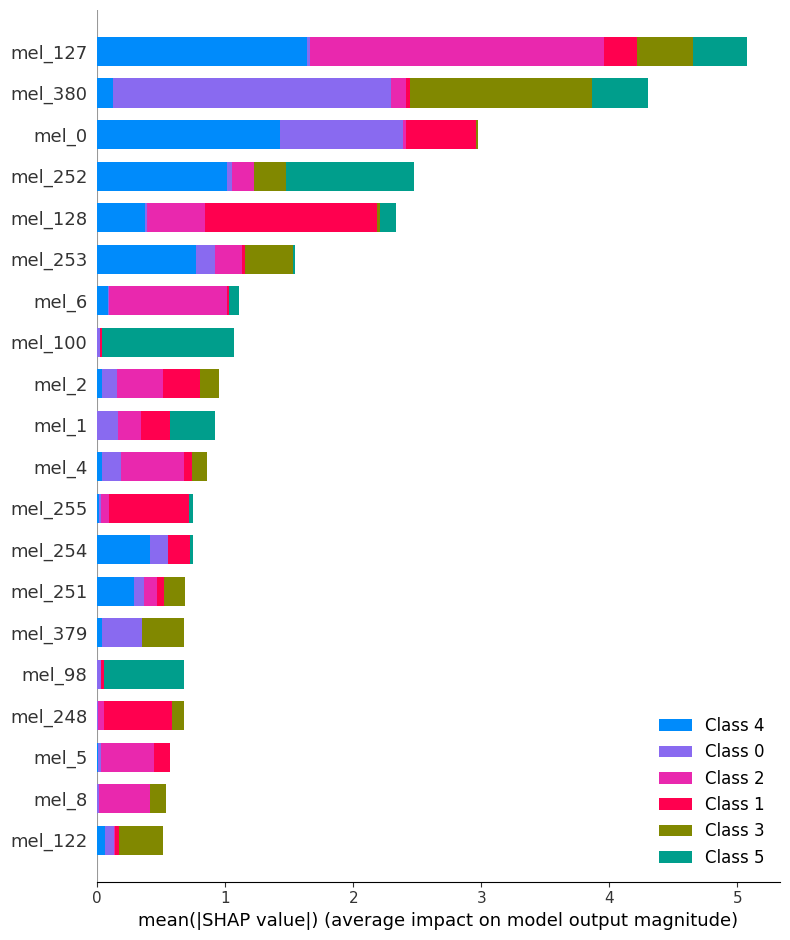

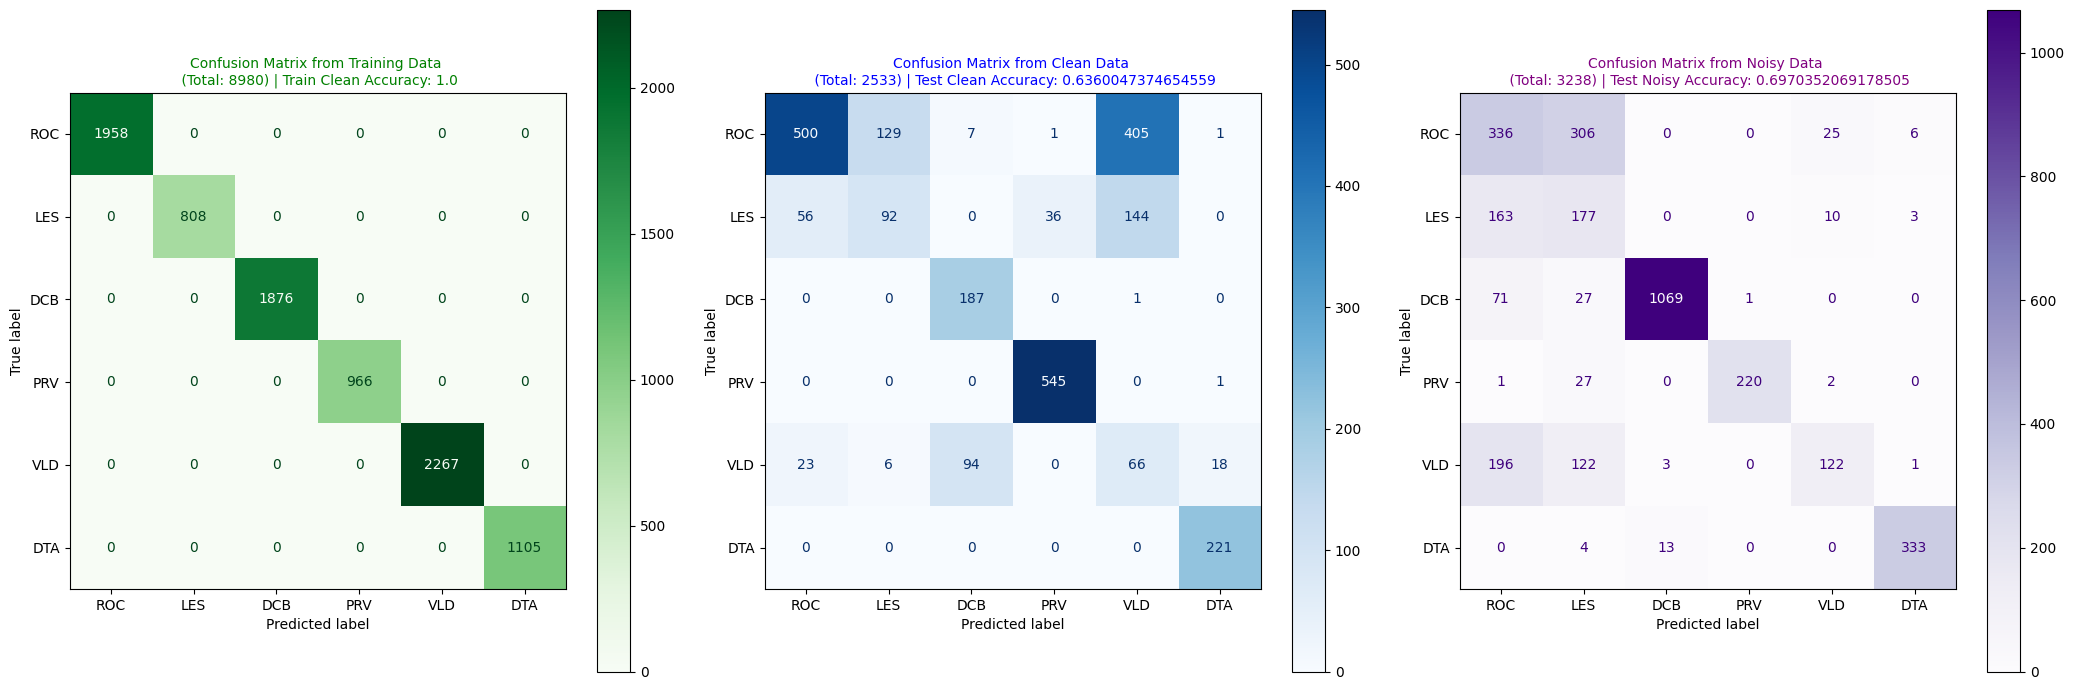

  6%|▋         | 1/16 [00:04<01:04,  4.28s/it]

Index: 1
Combination of Algorithm: MFCC

Shape of Train DataFrame: (8980, 36)
Shape of Test Clean DataFrame: (2533, 36)
Shape of Test Noisy DataFrame: (3238, 36)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.5258586656138966
Test Noisy Acc = 0.4592340951204447

**************************************************



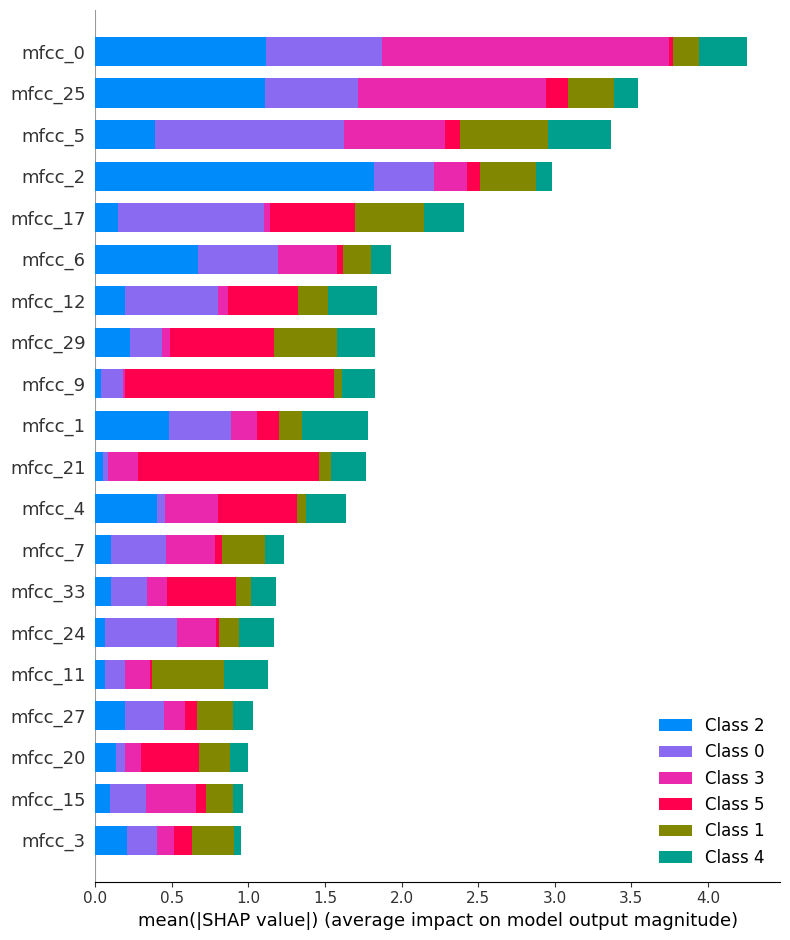

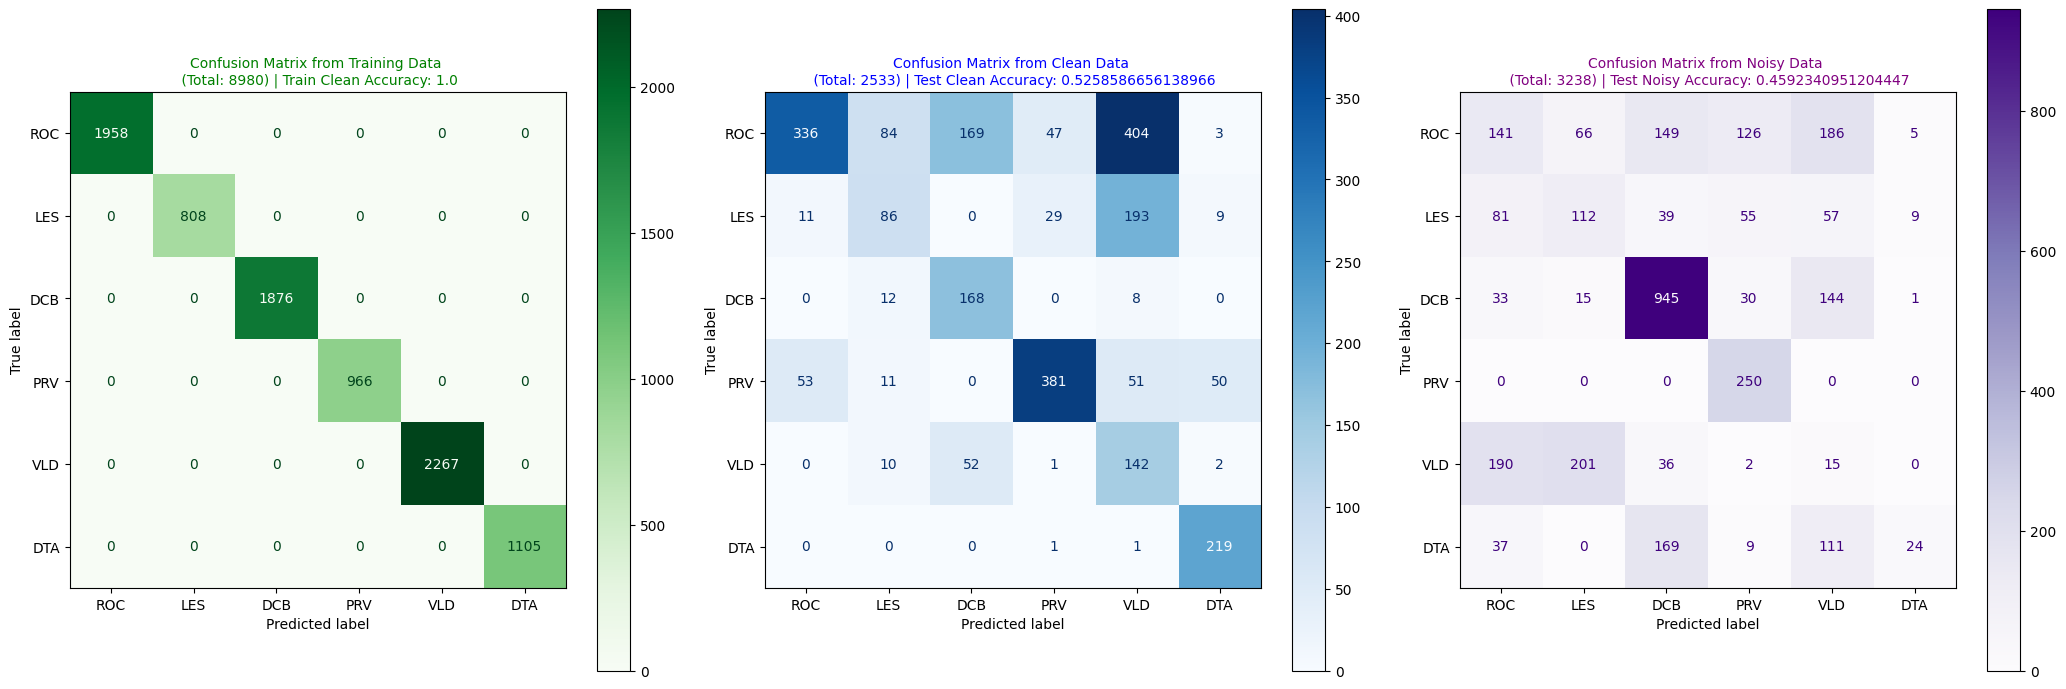

 12%|█▎        | 2/16 [00:06<00:45,  3.24s/it]

Index: 2
Combination of Algorithm: GTCC

Shape of Train DataFrame: (8980, 1491)
Shape of Test Clean DataFrame: (2533, 1491)
Shape of Test Noisy DataFrame: (3238, 1491)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.42123963679431503
Test Noisy Acc = 0.4870290302655961

**************************************************



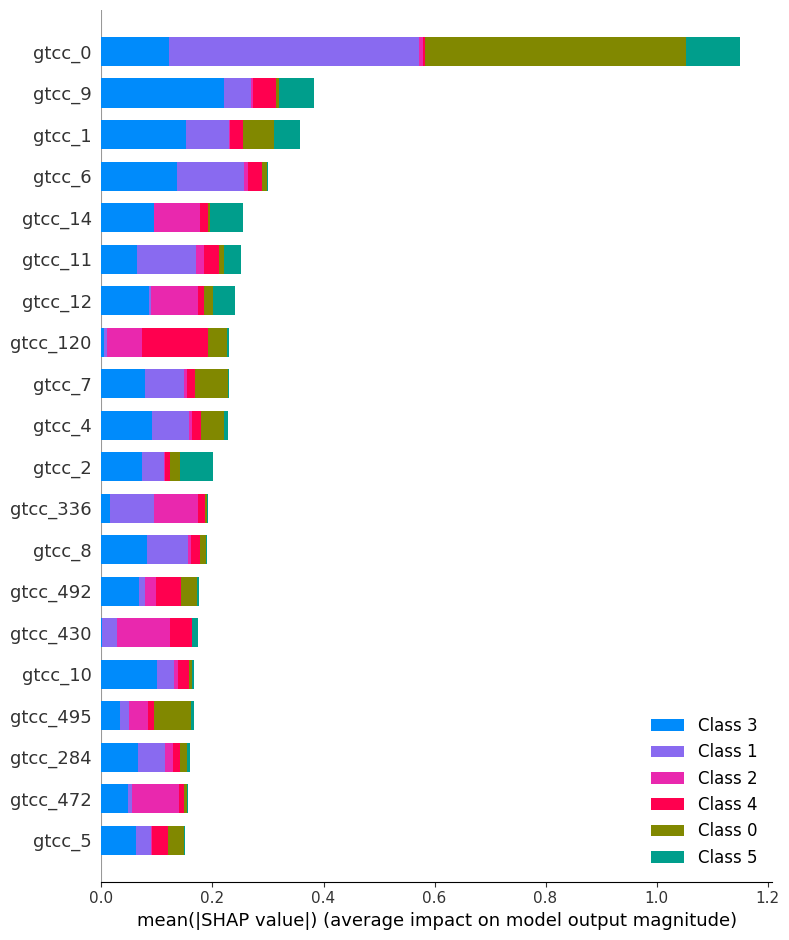

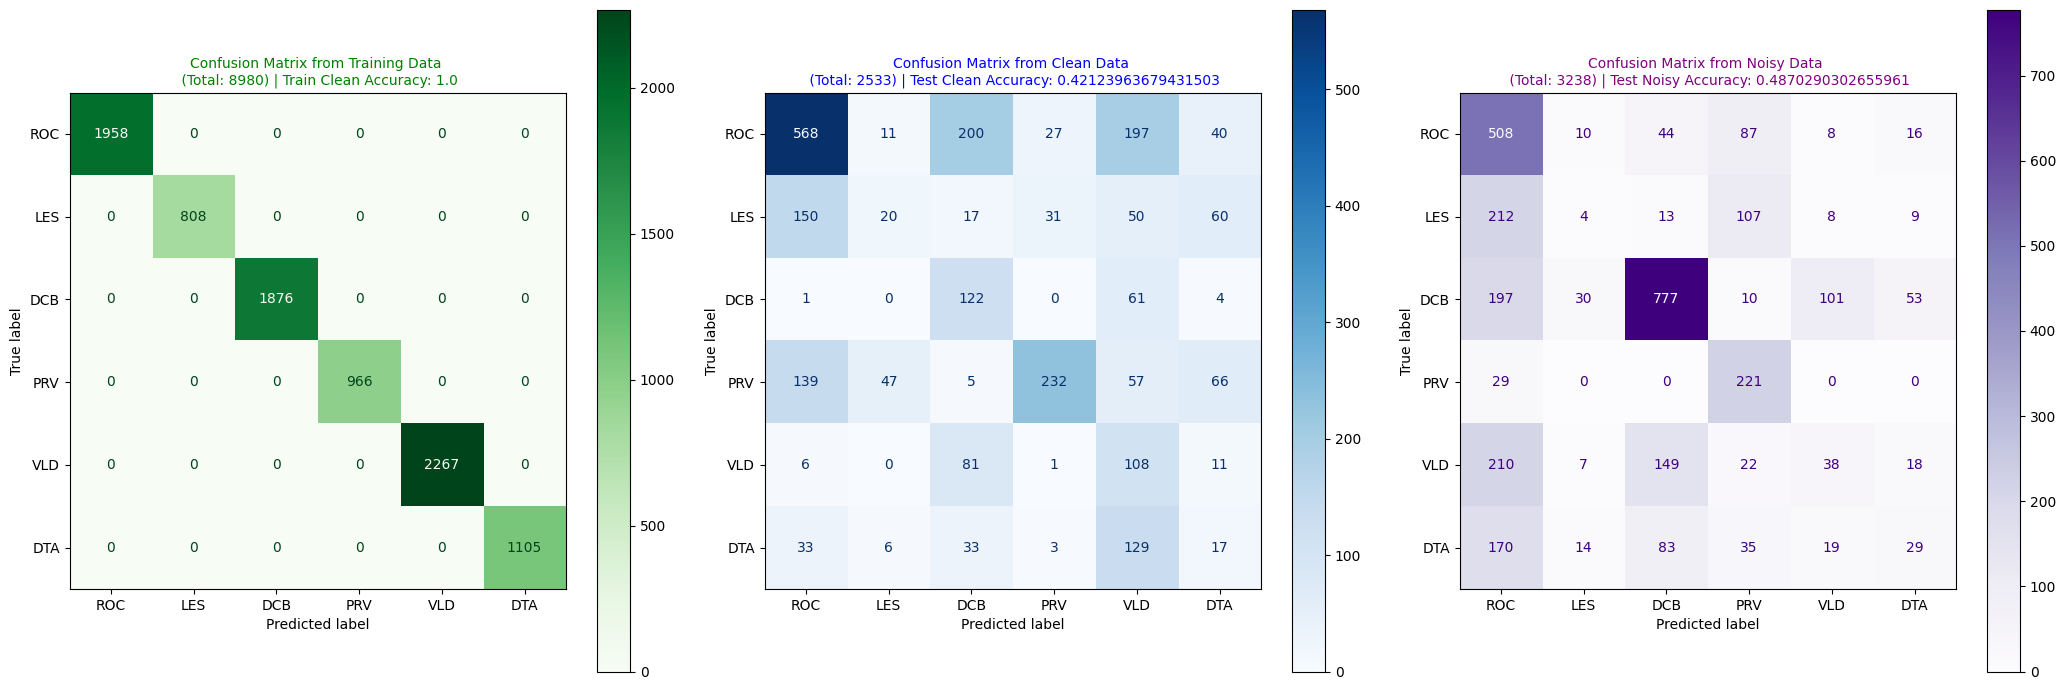

 19%|█▉        | 3/16 [00:37<03:25, 15.83s/it]

Index: 3
Combination of Algorithm: PNCC

Shape of Train DataFrame: (8980, 1491)
Shape of Test Clean DataFrame: (2533, 1491)
Shape of Test Noisy DataFrame: (3238, 1491)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.4330833004342677
Test Noisy Acc = 0.474366893143916

**************************************************



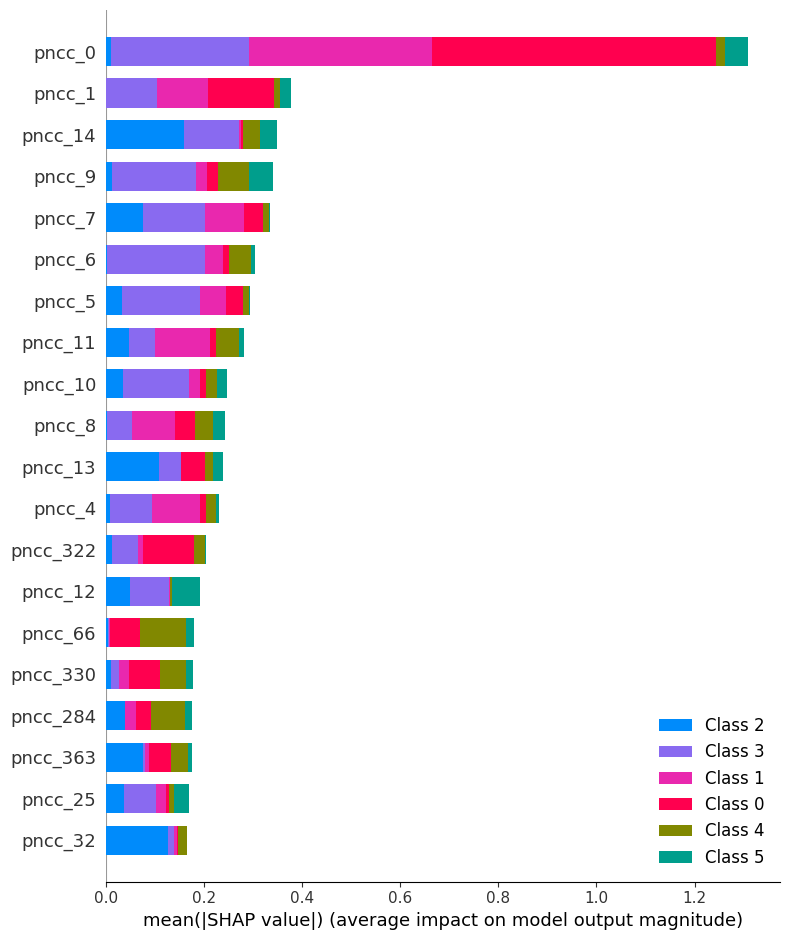

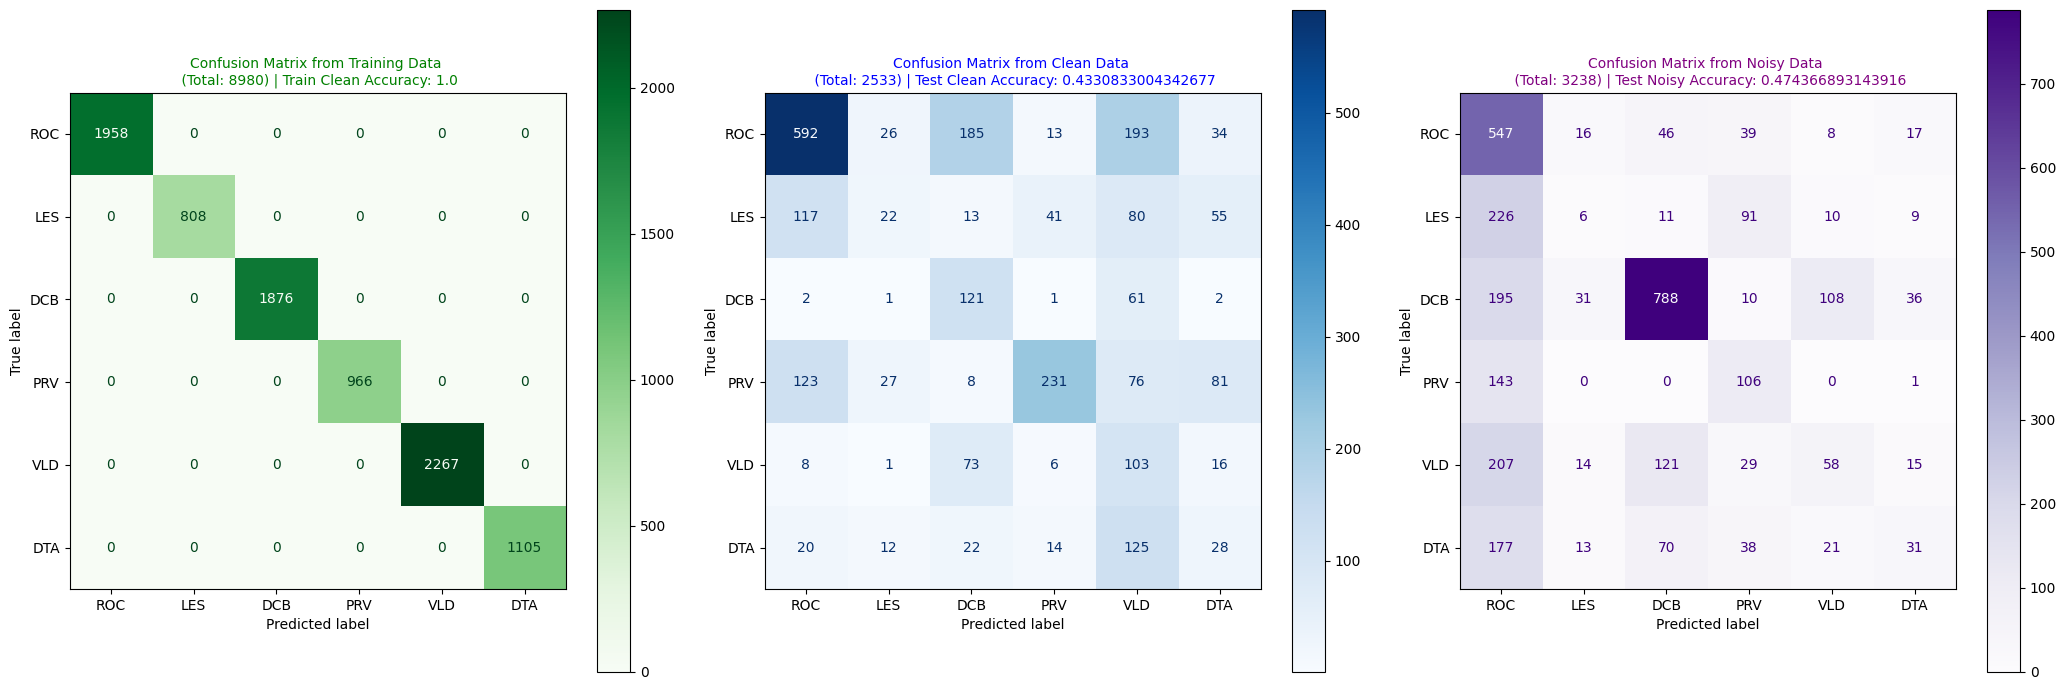

 25%|██▌       | 4/16 [01:10<04:28, 22.38s/it]

Index: 4
Combination of Algorithm: LFCC

Shape of Train DataFrame: (8980, 1491)
Shape of Test Clean DataFrame: (2533, 1491)
Shape of Test Noisy DataFrame: (3238, 1491)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.32846427161468617
Test Noisy Acc = 0.38511426806670784

**************************************************



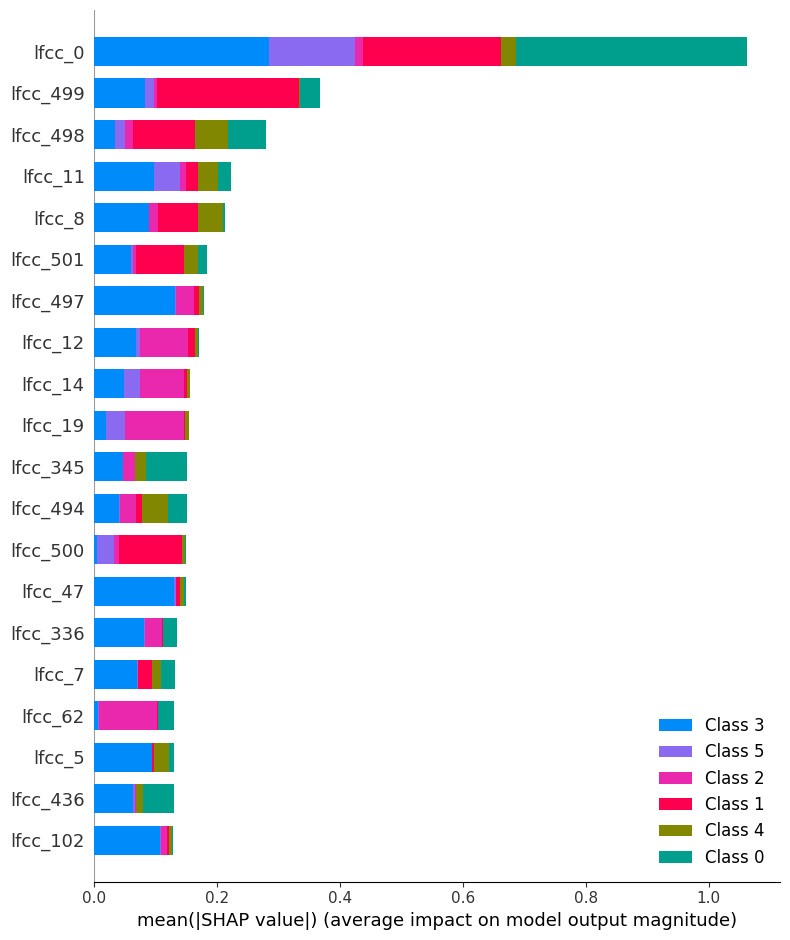

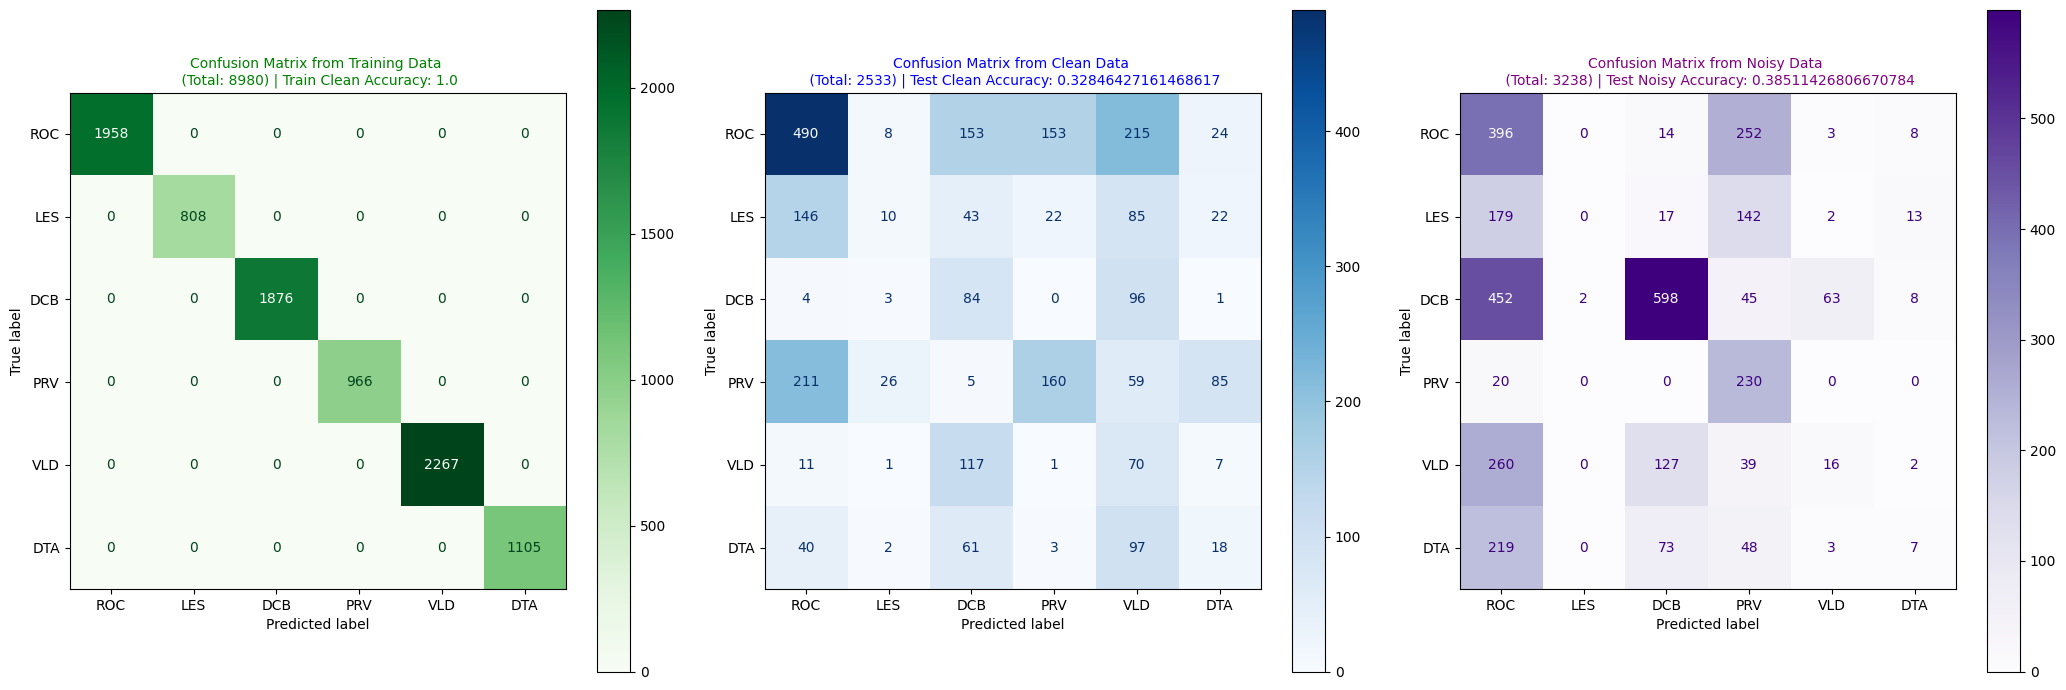

 31%|███▏      | 5/16 [01:41<04:41, 25.62s/it]

Index: 5
Combination of Algorithm: PLP

Shape of Train DataFrame: (8980, 13)
Shape of Test Clean DataFrame: (2533, 13)
Shape of Test Noisy DataFrame: (3238, 13)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.4484800631662061
Test Noisy Acc = 0.35948116121062385

**************************************************



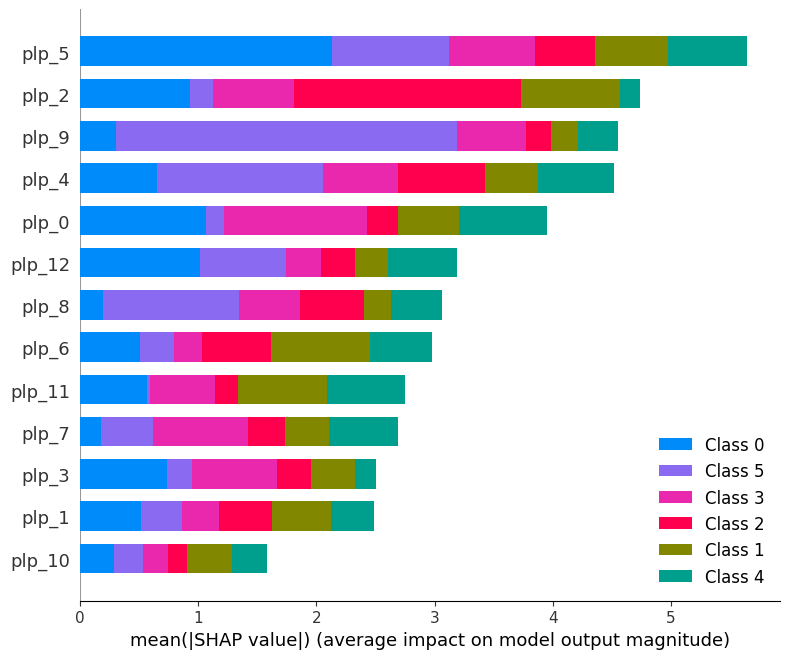

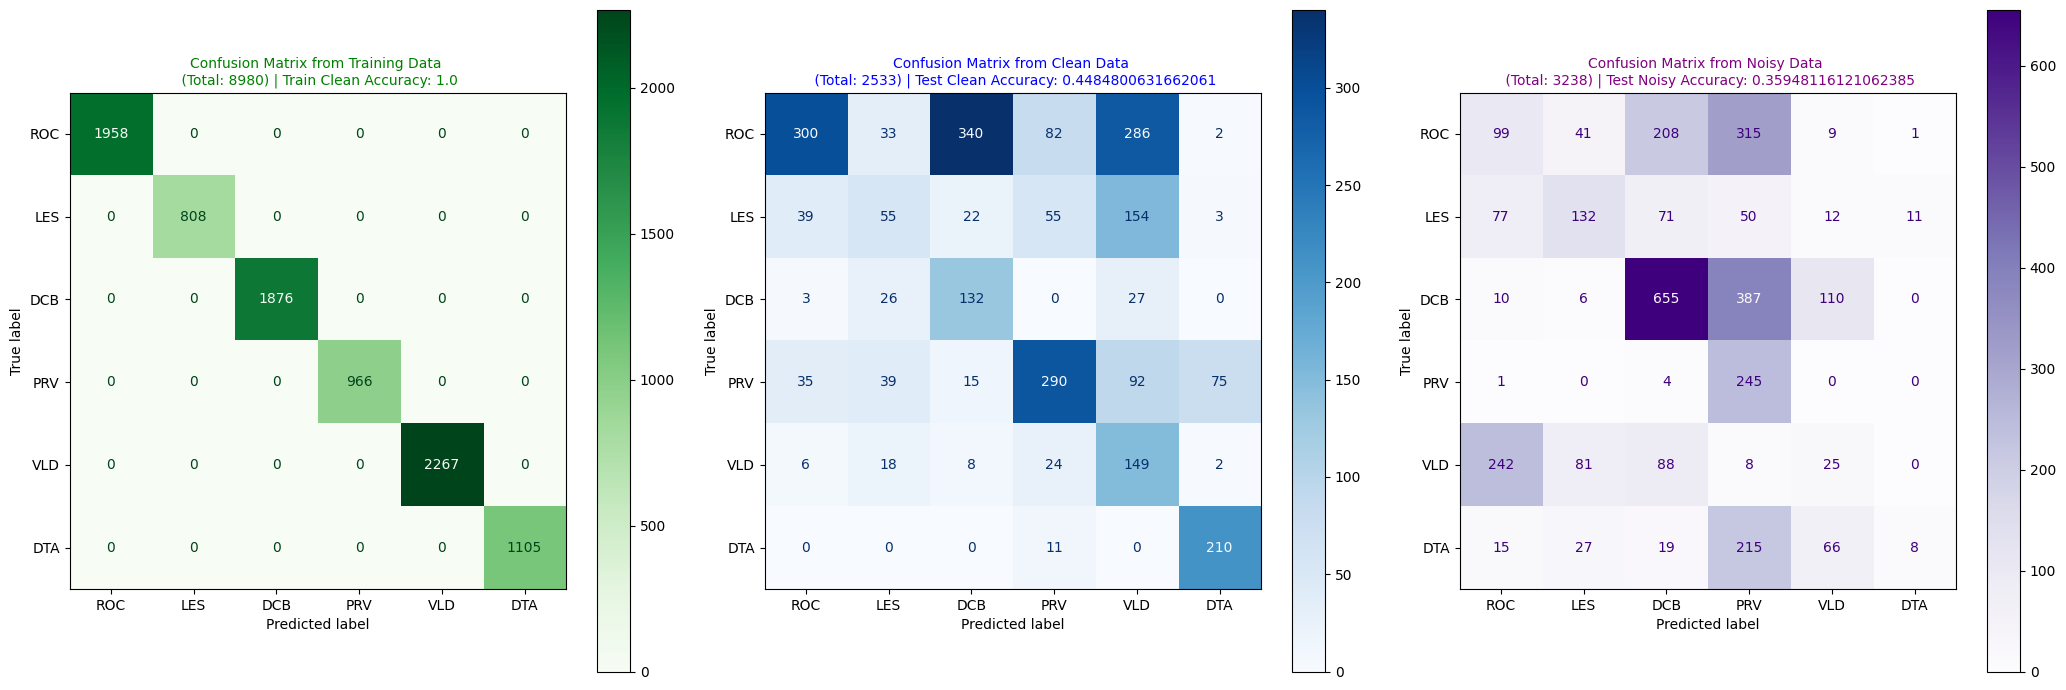

 38%|███▊      | 6/16 [01:44<02:58, 17.88s/it]

Index: 6
Combination of Algorithm: LPC_16

Shape of Train DataFrame: (8980, 48)
Shape of Test Clean DataFrame: (2533, 48)
Shape of Test Noisy DataFrame: (3238, 48)

Accuracy Results:
--------------------
Train Clean Acc = 0.9998886414253898
Test Clean Acc = 0.5692854322937229
Test Noisy Acc = 0.6142680667078444

**************************************************



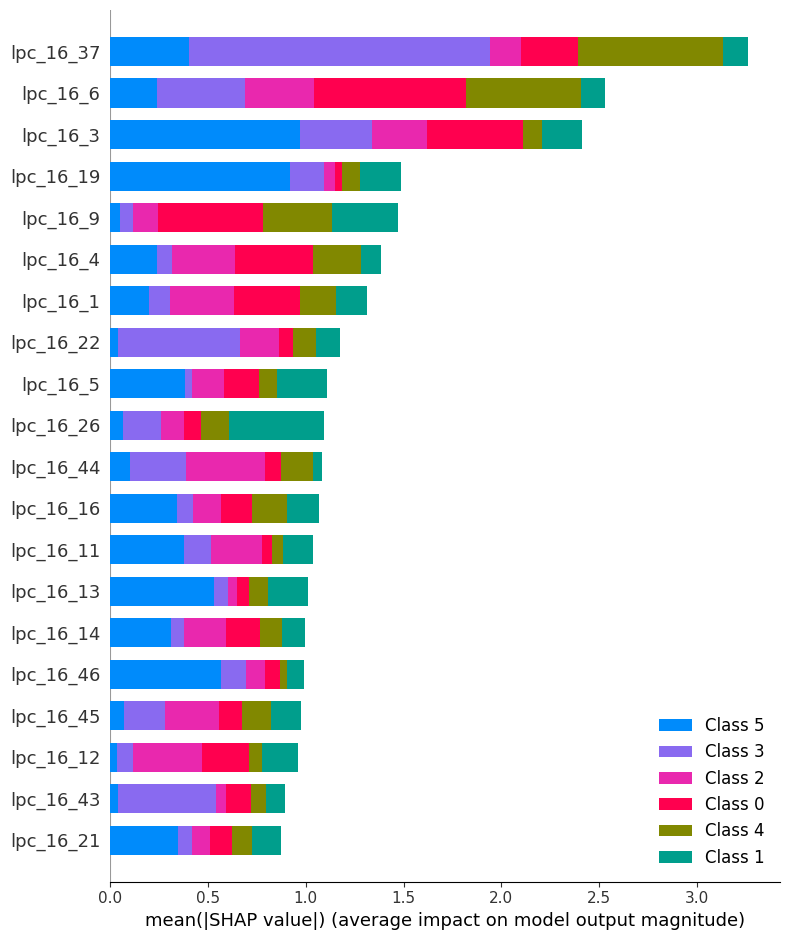

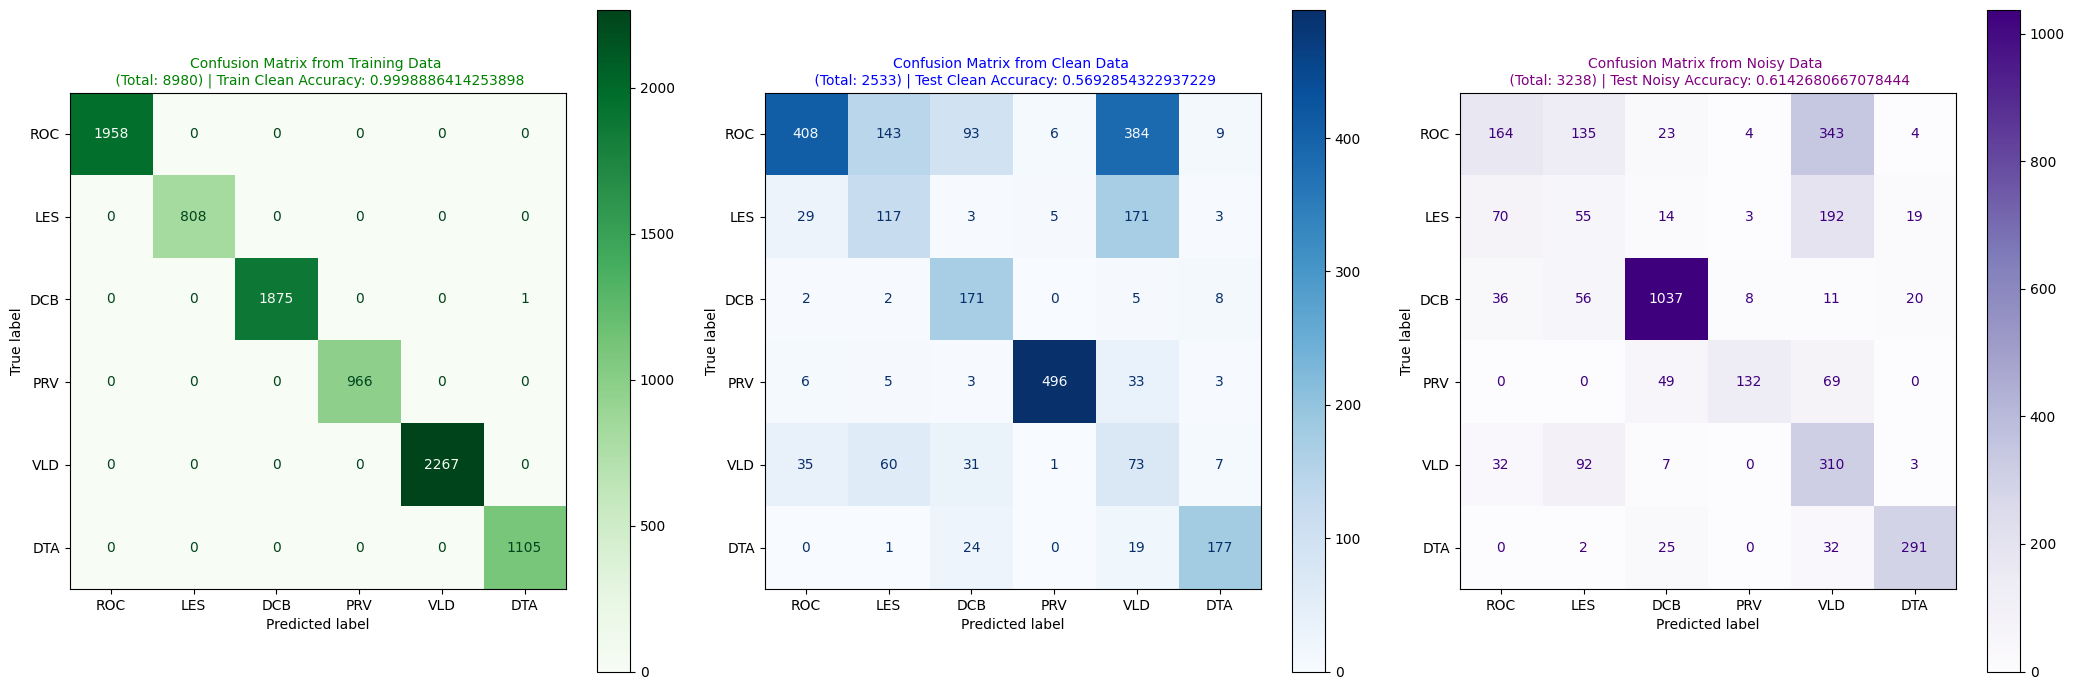

 44%|████▍     | 7/16 [01:47<01:58, 13.20s/it]

Index: 7
Combination of Algorithm: LPC_26

Shape of Train DataFrame: (8980, 78)
Shape of Test Clean DataFrame: (2533, 78)
Shape of Test Noisy DataFrame: (3238, 78)

Accuracy Results:
--------------------
Train Clean Acc = 0.9914253897550112
Test Clean Acc = 0.6344255823134622
Test Noisy Acc = 0.6312538604076591

**************************************************



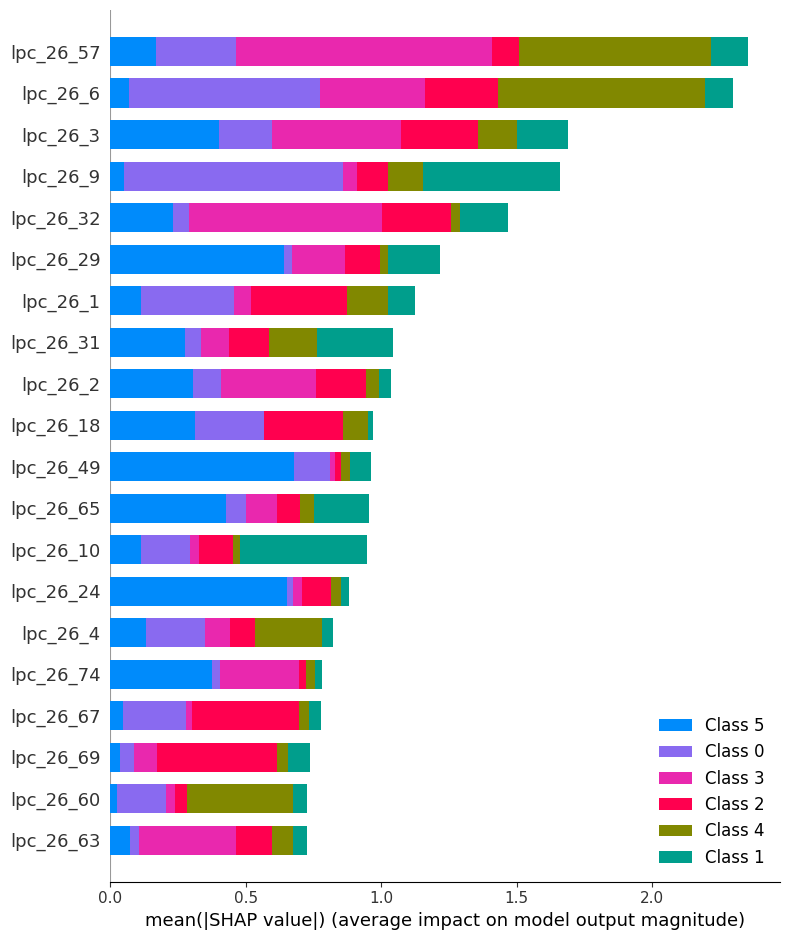

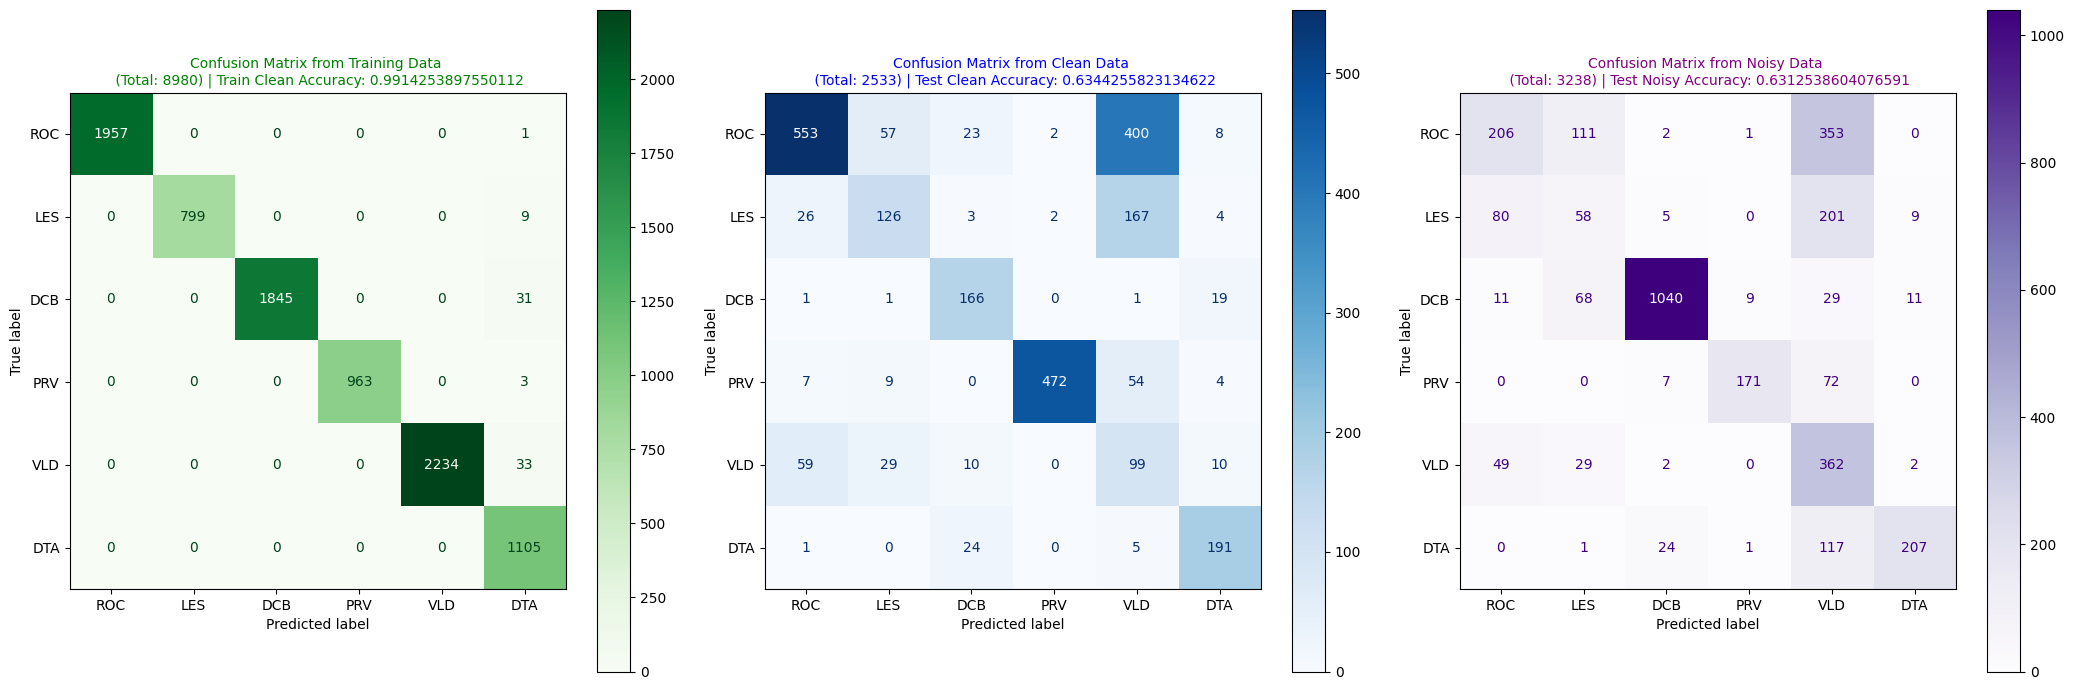

 50%|█████     | 8/16 [01:51<01:22, 10.31s/it]

Index: 8
Combination of Algorithm: X-VECTOR

Shape of Train DataFrame: (8980, 512)
Shape of Test Clean DataFrame: (2533, 512)
Shape of Test Noisy DataFrame: (3238, 512)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.3549151204105803
Test Noisy Acc = 0.458307597282273

**************************************************



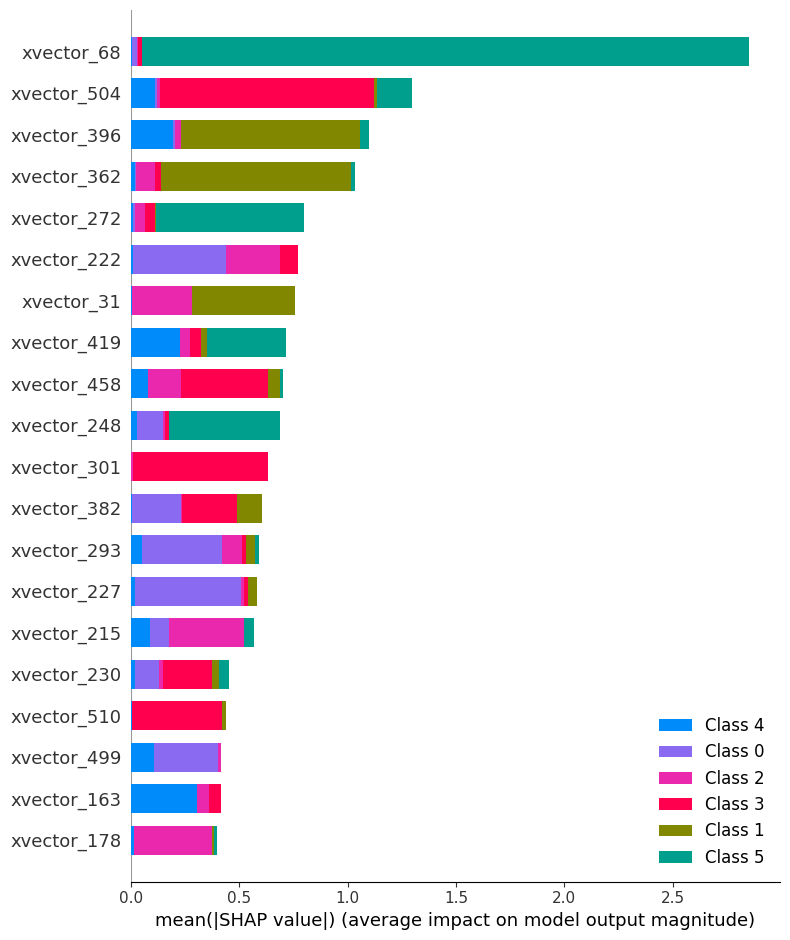

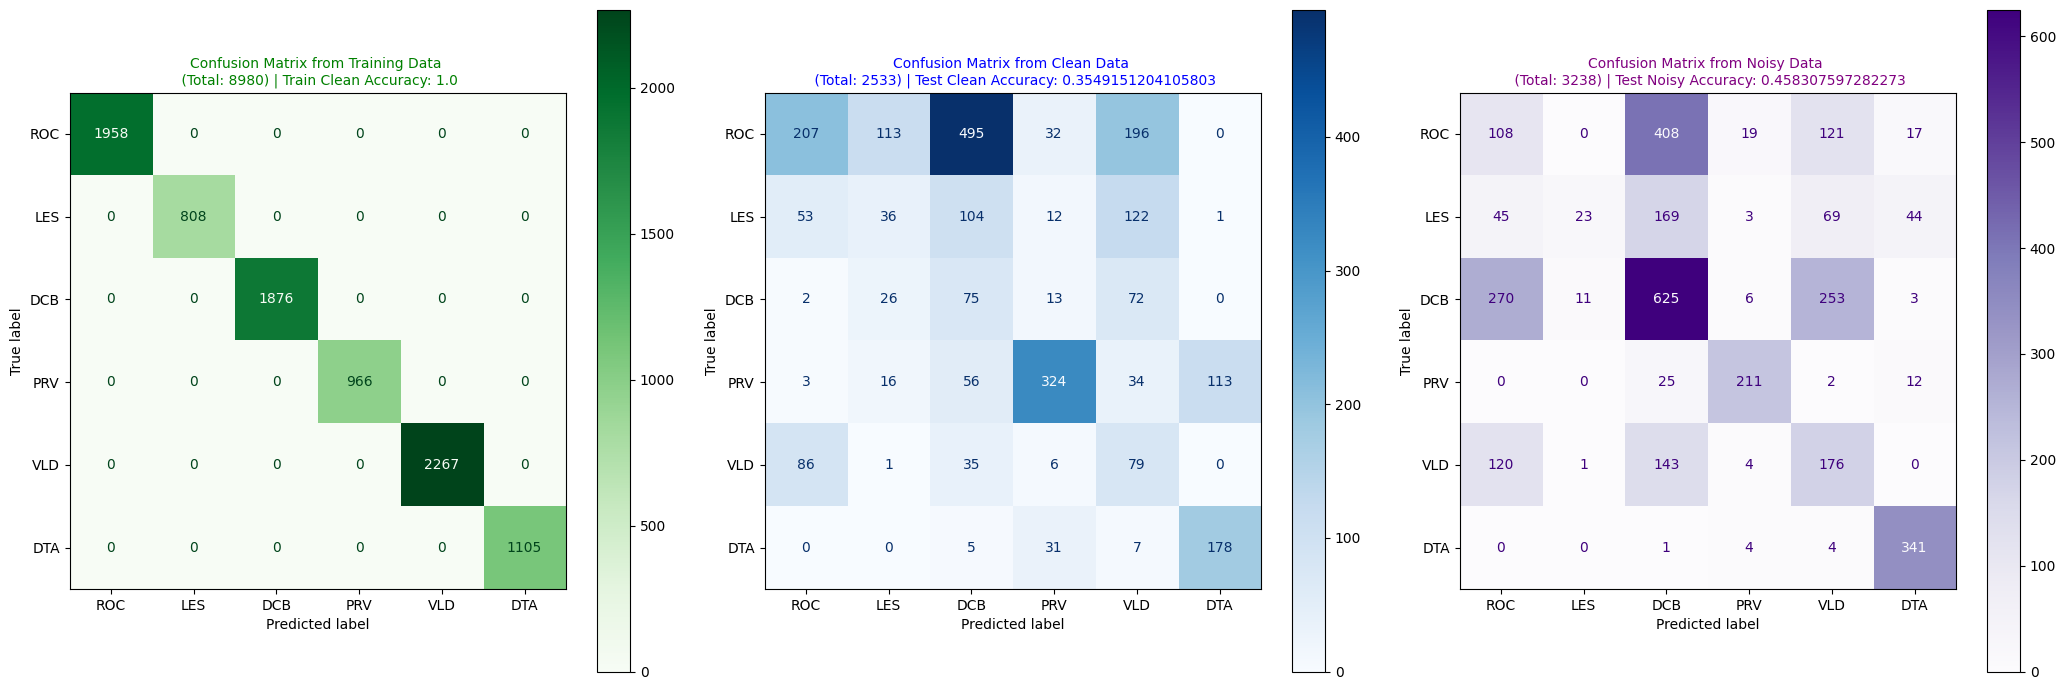

 56%|█████▋    | 9/16 [01:59<01:06,  9.47s/it]

Index: 9
Combination of Algorithm: Wav2Vec2

Shape of Train DataFrame: (8980, 768)
Shape of Test Clean DataFrame: (2533, 768)
Shape of Test Noisy DataFrame: (3238, 768)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.25582313462297673
Test Noisy Acc = 0.2683755404570723

**************************************************



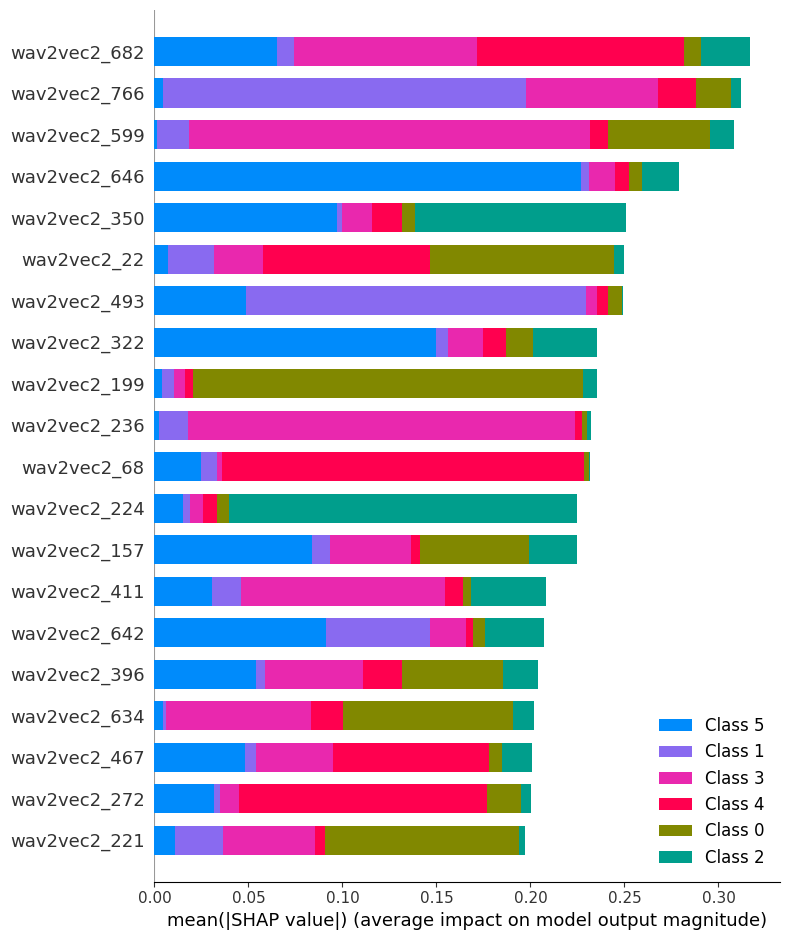

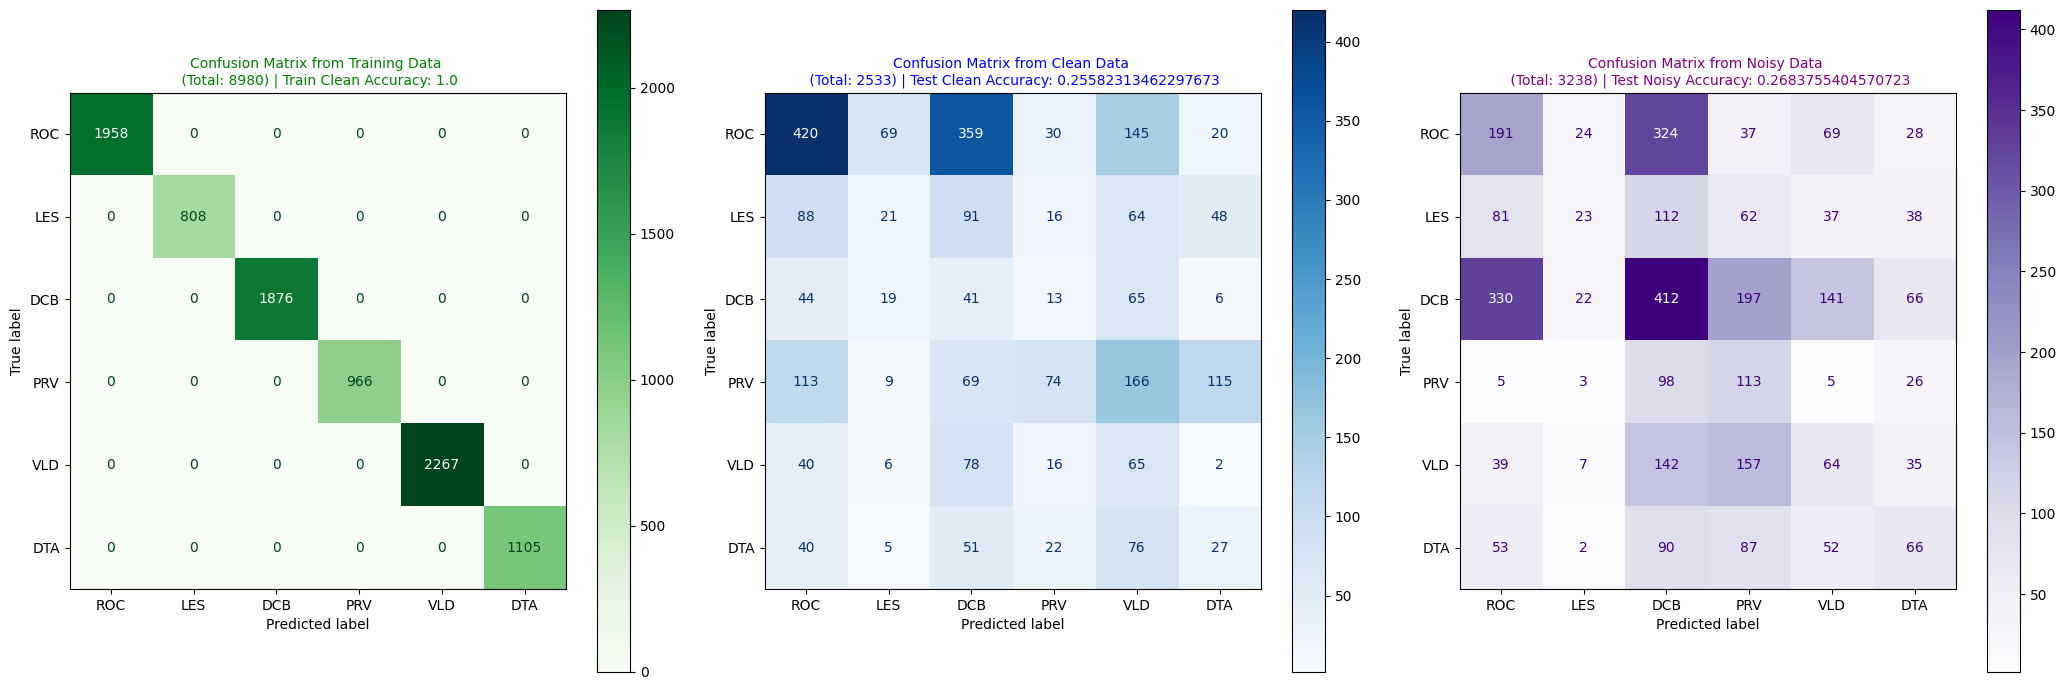

 62%|██████▎   | 10/16 [02:18<01:14, 12.39s/it]

Index: 10
Combination of Algorithm: OS_ComParE

Shape of Train DataFrame: (8980, 6373)
Shape of Test Clean DataFrame: (2533, 6373)
Shape of Test Noisy DataFrame: (3238, 6373)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.6154757204895381
Test Noisy Acc = 0.5880172946263126

**************************************************



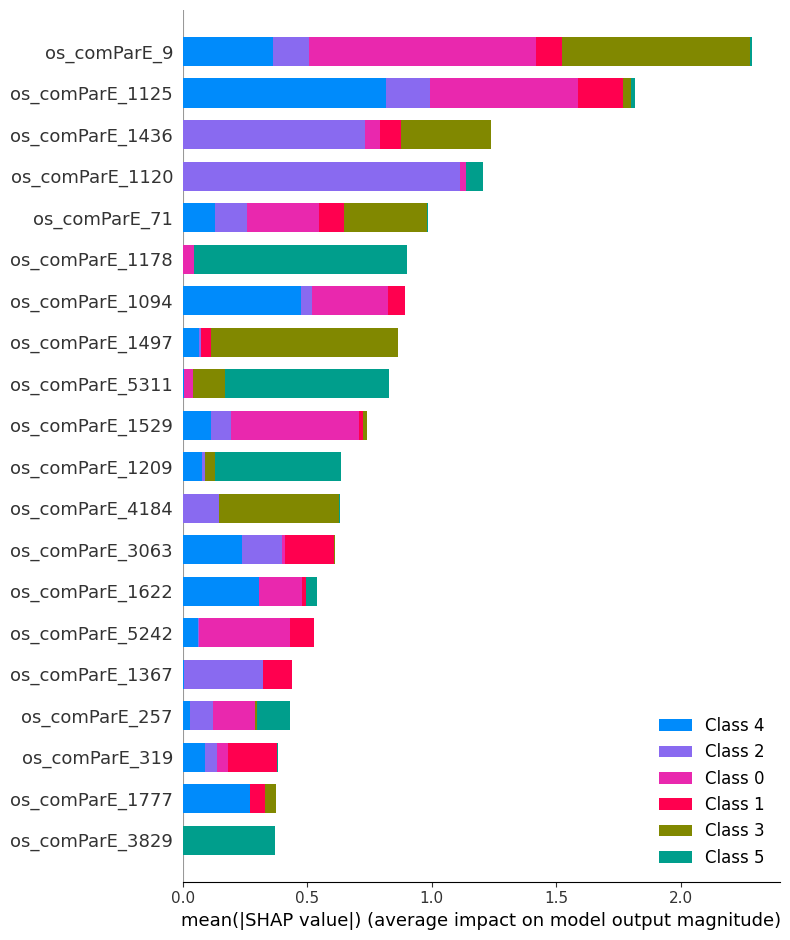

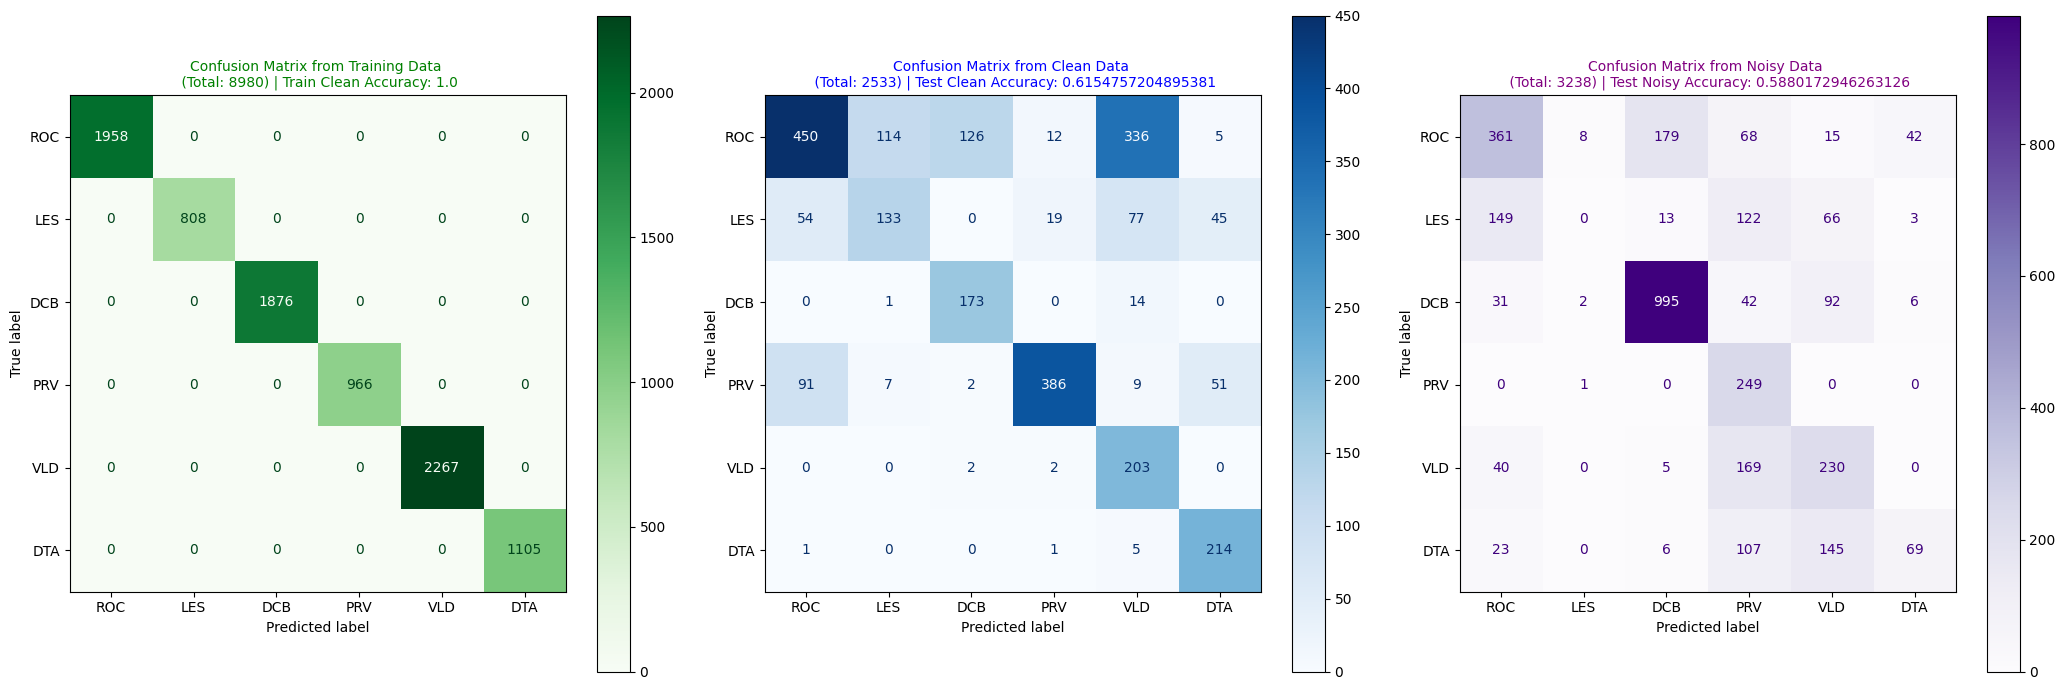

 69%|██████▉   | 11/16 [03:16<02:12, 26.45s/it]

Index: 11
Combination of Algorithm: OS_GeMAPSv01b

Shape of Train DataFrame: (8980, 8928)
Shape of Test Clean DataFrame: (2533, 8928)
Shape of Test Noisy DataFrame: (3238, 8928)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.3300434267666798
Test Noisy Acc = 0.38604076590487957

**************************************************



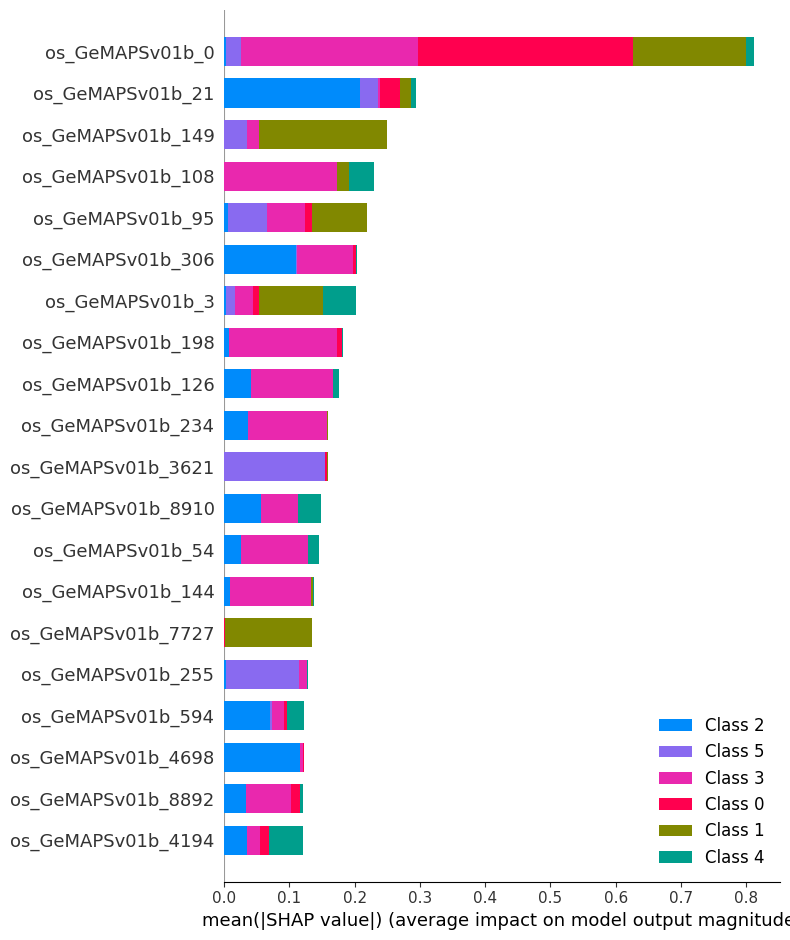

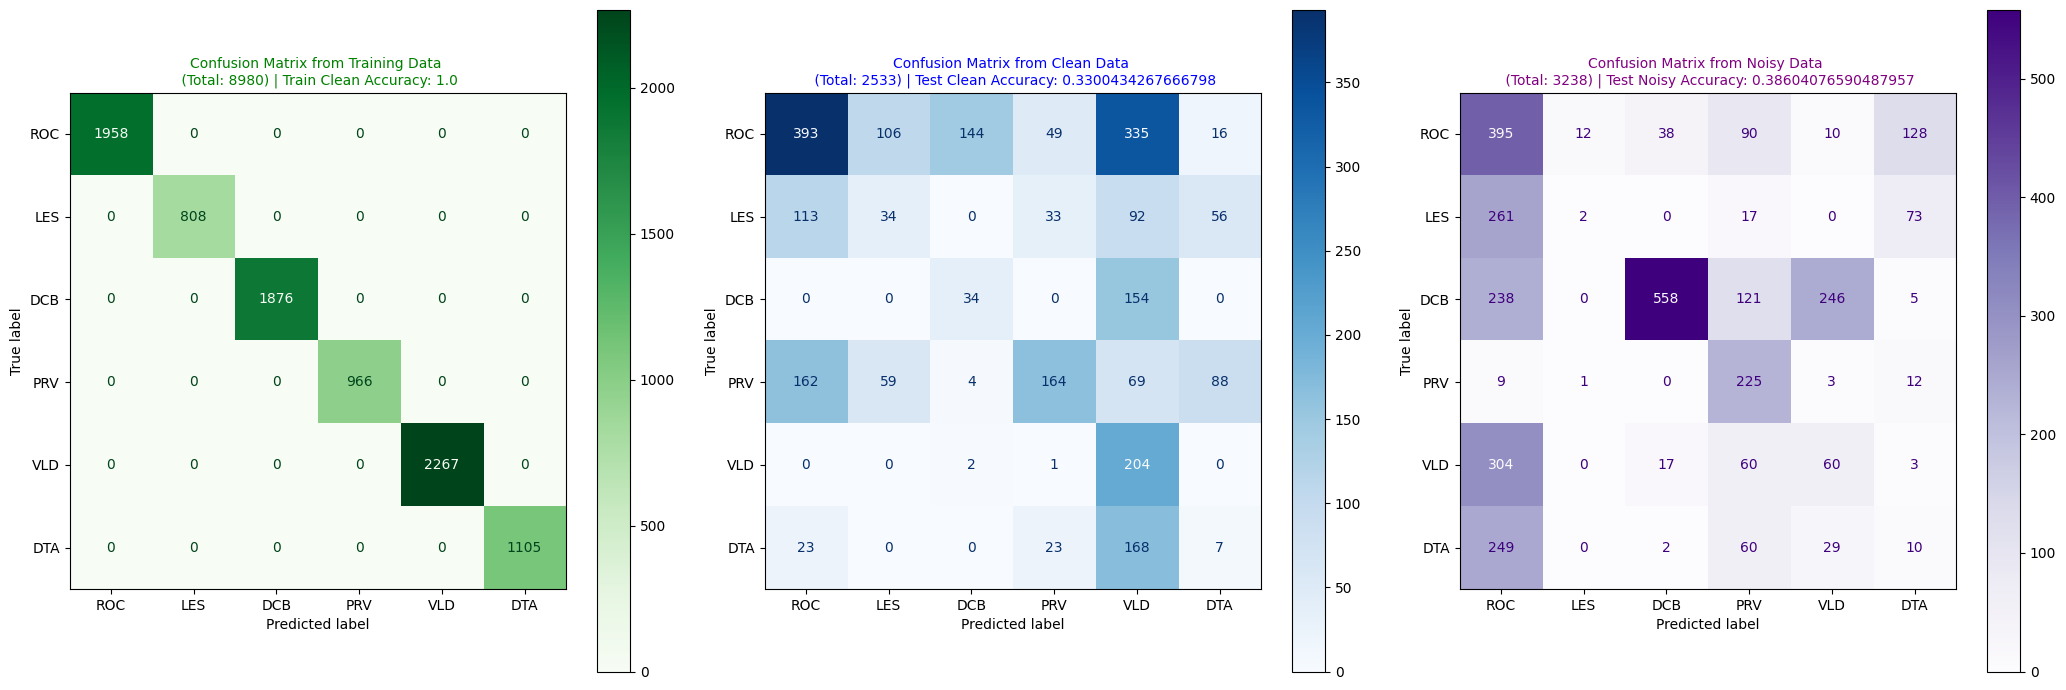

 75%|███████▌  | 12/16 [05:43<04:12, 63.12s/it]

Index: 12
Combination of Algorithm: OS_eGeMAPSv02

Shape of Train DataFrame: (8980, 12400)
Shape of Test Clean DataFrame: (2533, 12400)
Shape of Test Noisy DataFrame: (3238, 12400)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.31701539676273194
Test Noisy Acc = 0.4218653489808524

**************************************************



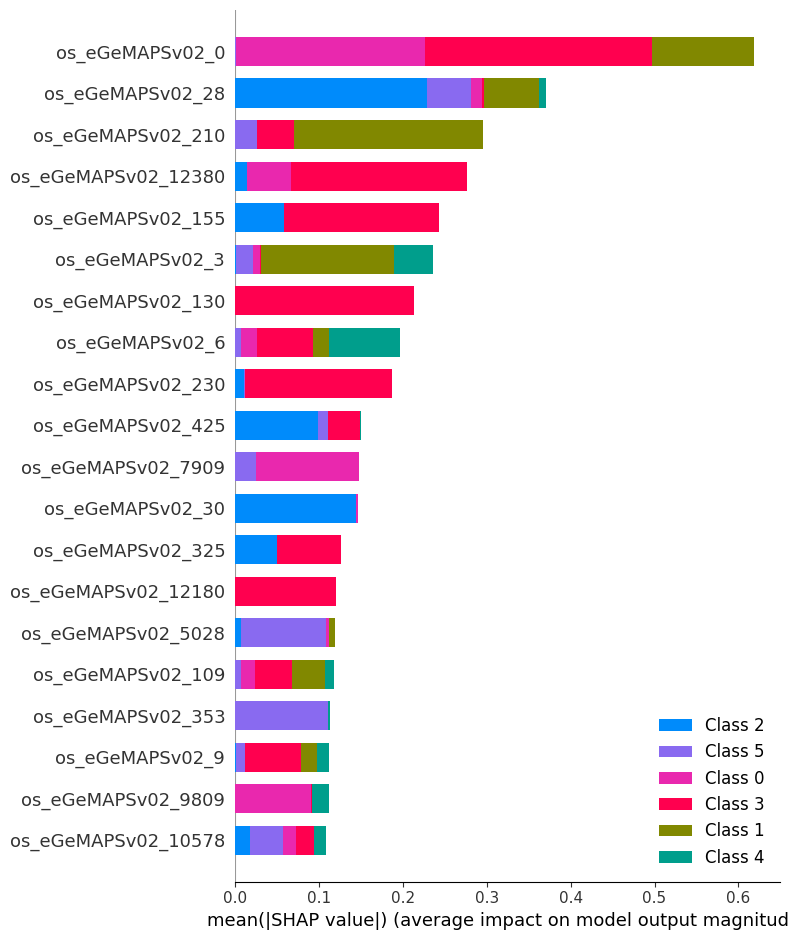

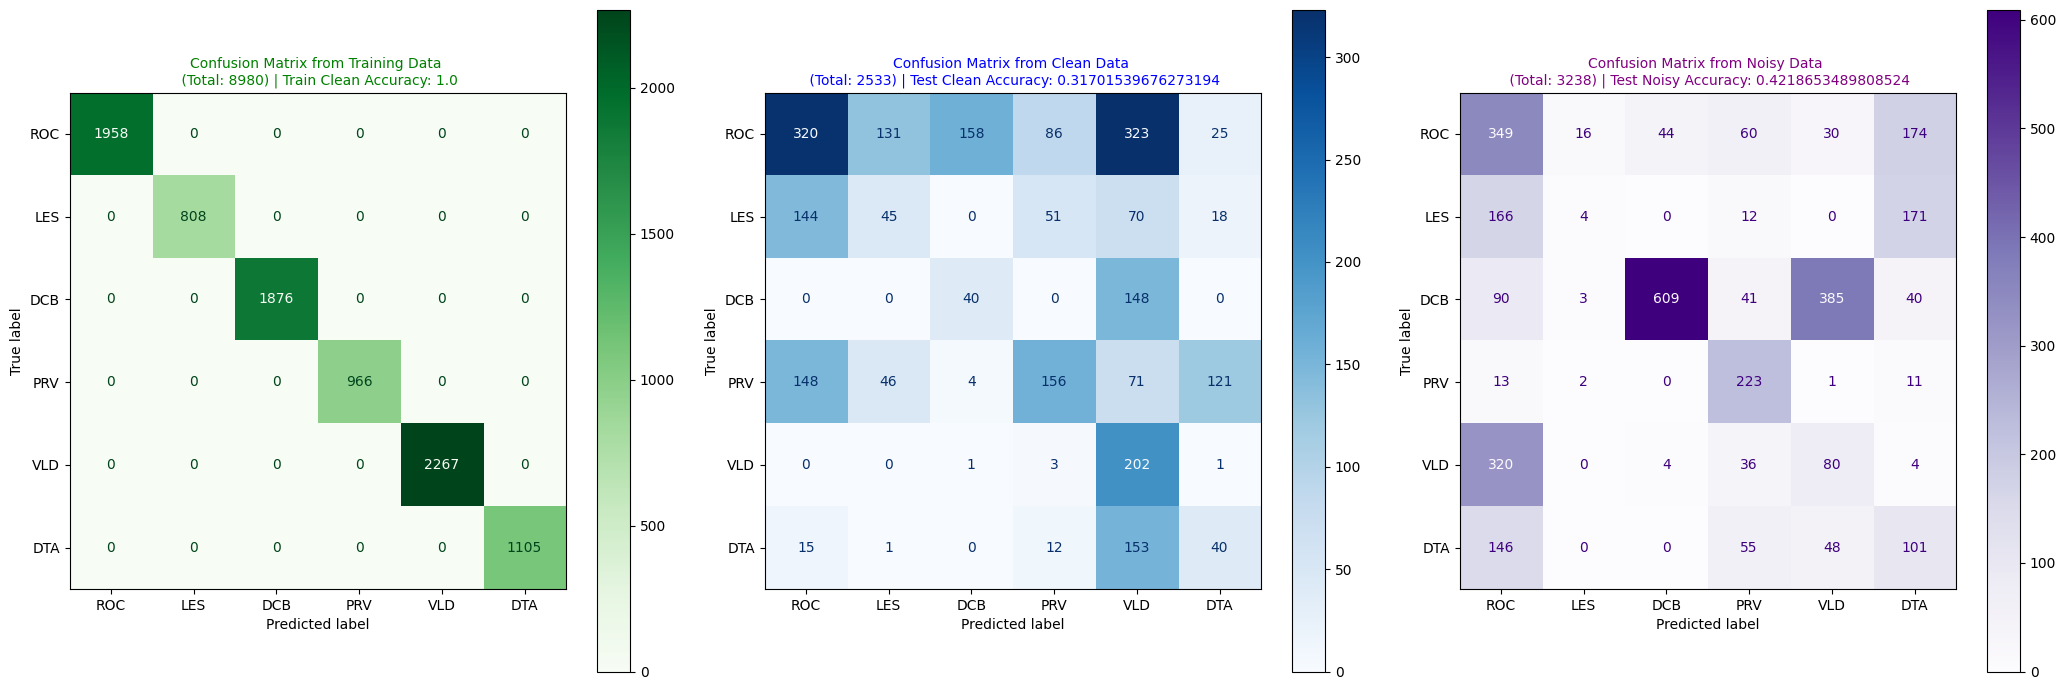

 81%|████████▏ | 13/16 [08:56<05:07, 102.52s/it]

Index: 13
Combination of Algorithm: MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26

Shape of Train DataFrame: (8980, 8759)
Shape of Test Clean DataFrame: (2533, 8759)
Shape of Test Noisy DataFrame: (3238, 8759)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.688511646269246
Test Noisy Acc = 0.718035824583076

**************************************************



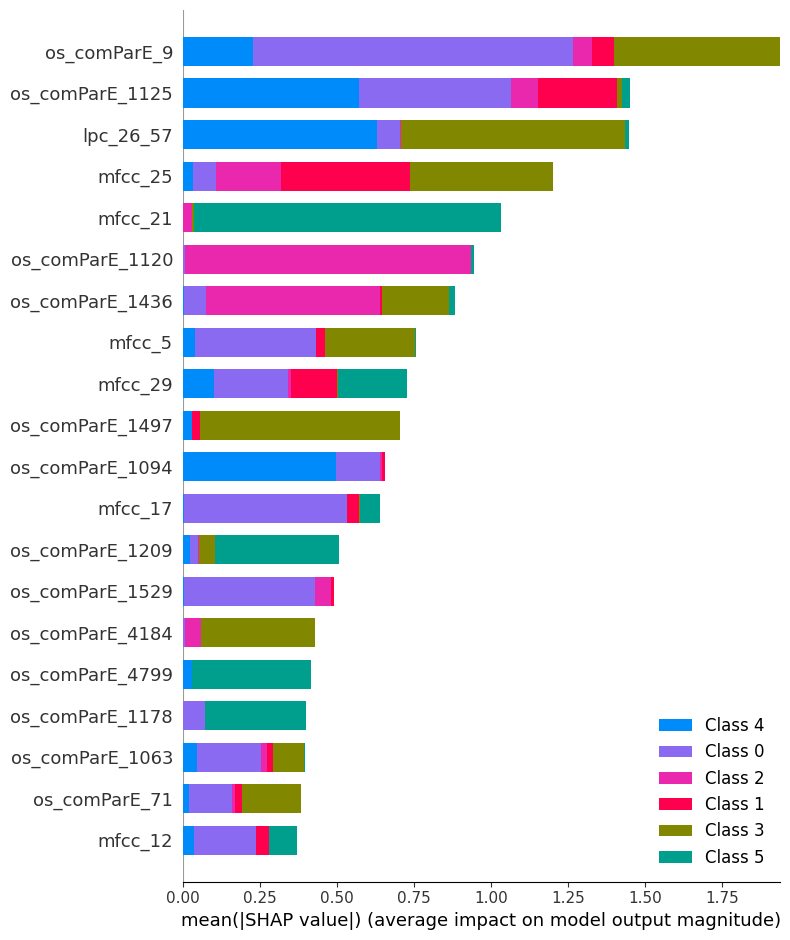

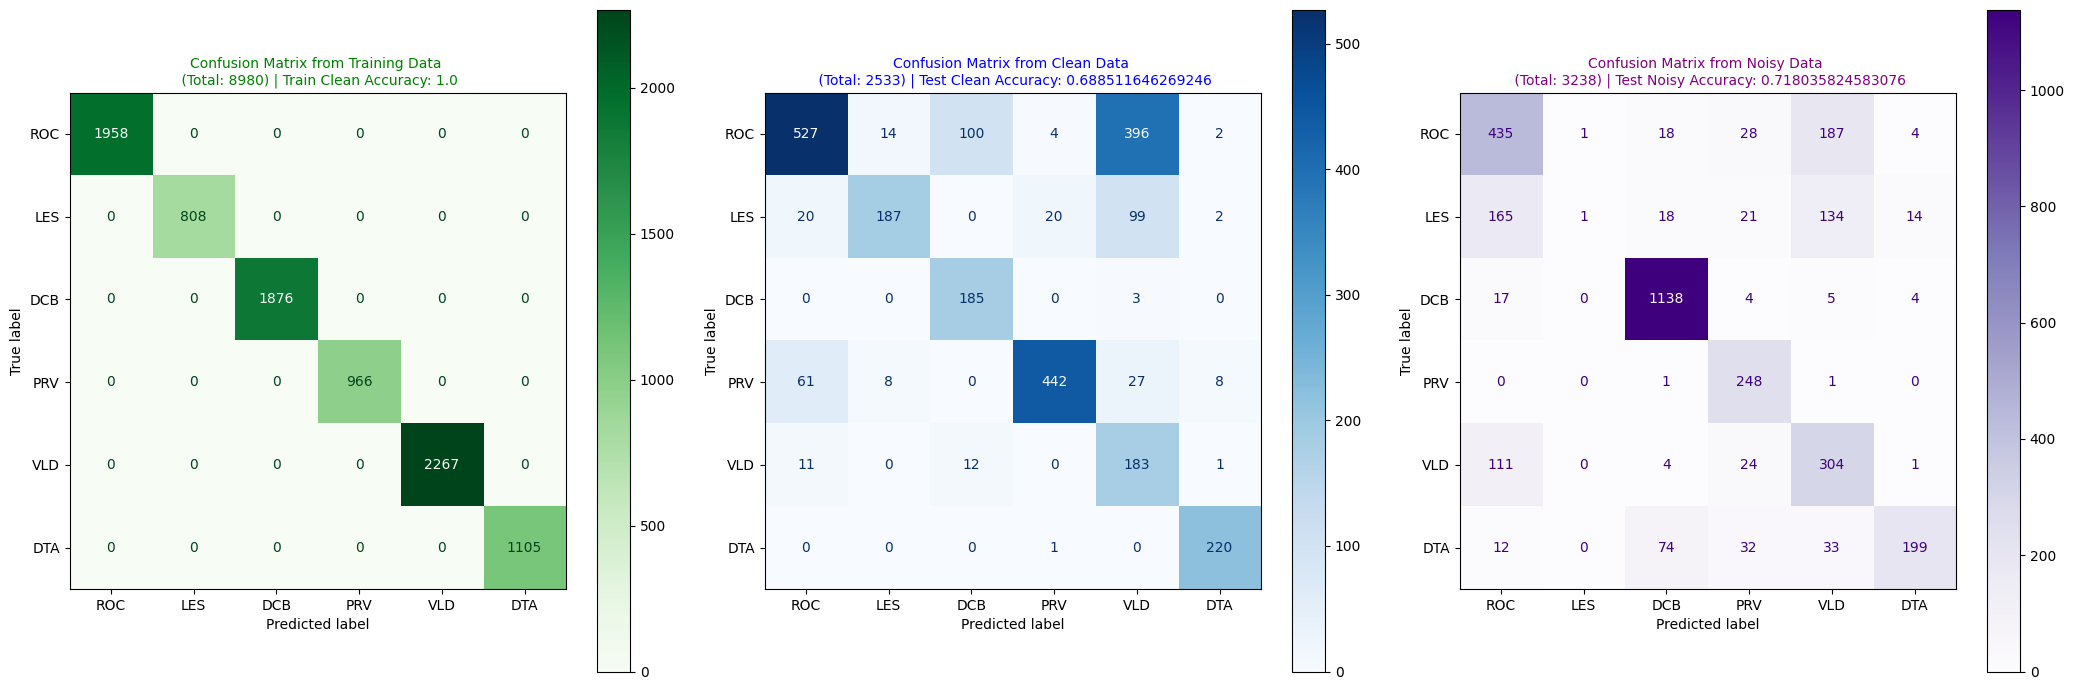

 88%|████████▊ | 14/16 [12:02<04:15, 127.60s/it]

Index: 14
Combination of Algorithm: MFCC + ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL

Shape of Train DataFrame: (8980, 9140)
Shape of Test Clean DataFrame: (2533, 9140)
Shape of Test Noisy DataFrame: (3238, 9140)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.693249111725227
Test Noisy Acc = 0.7415071031500926

**************************************************



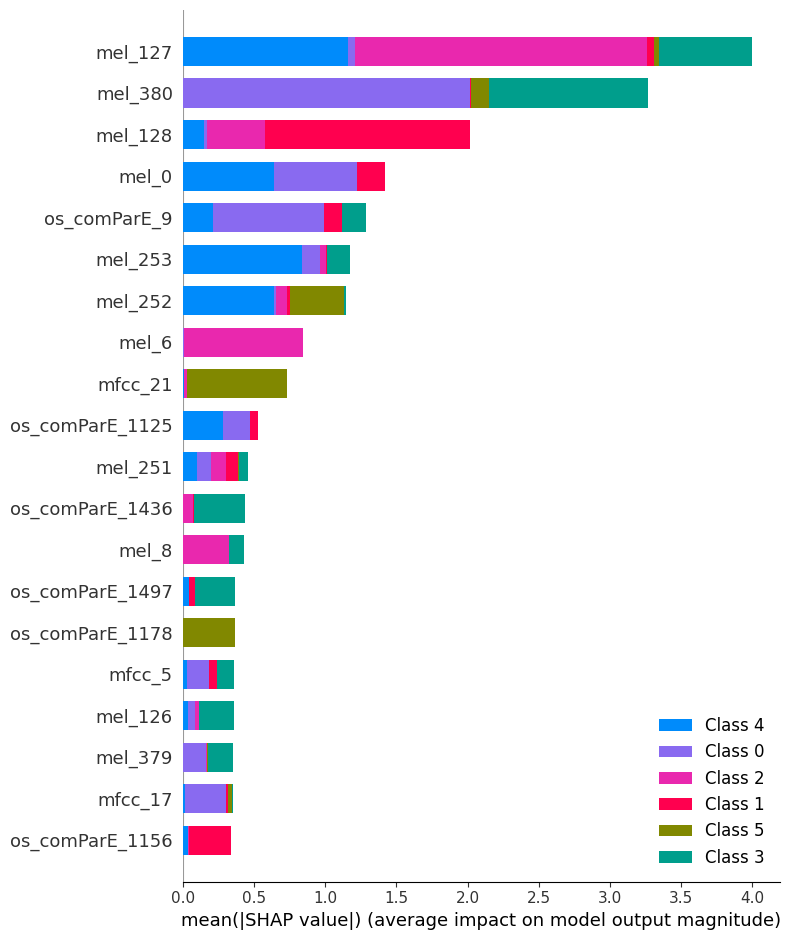

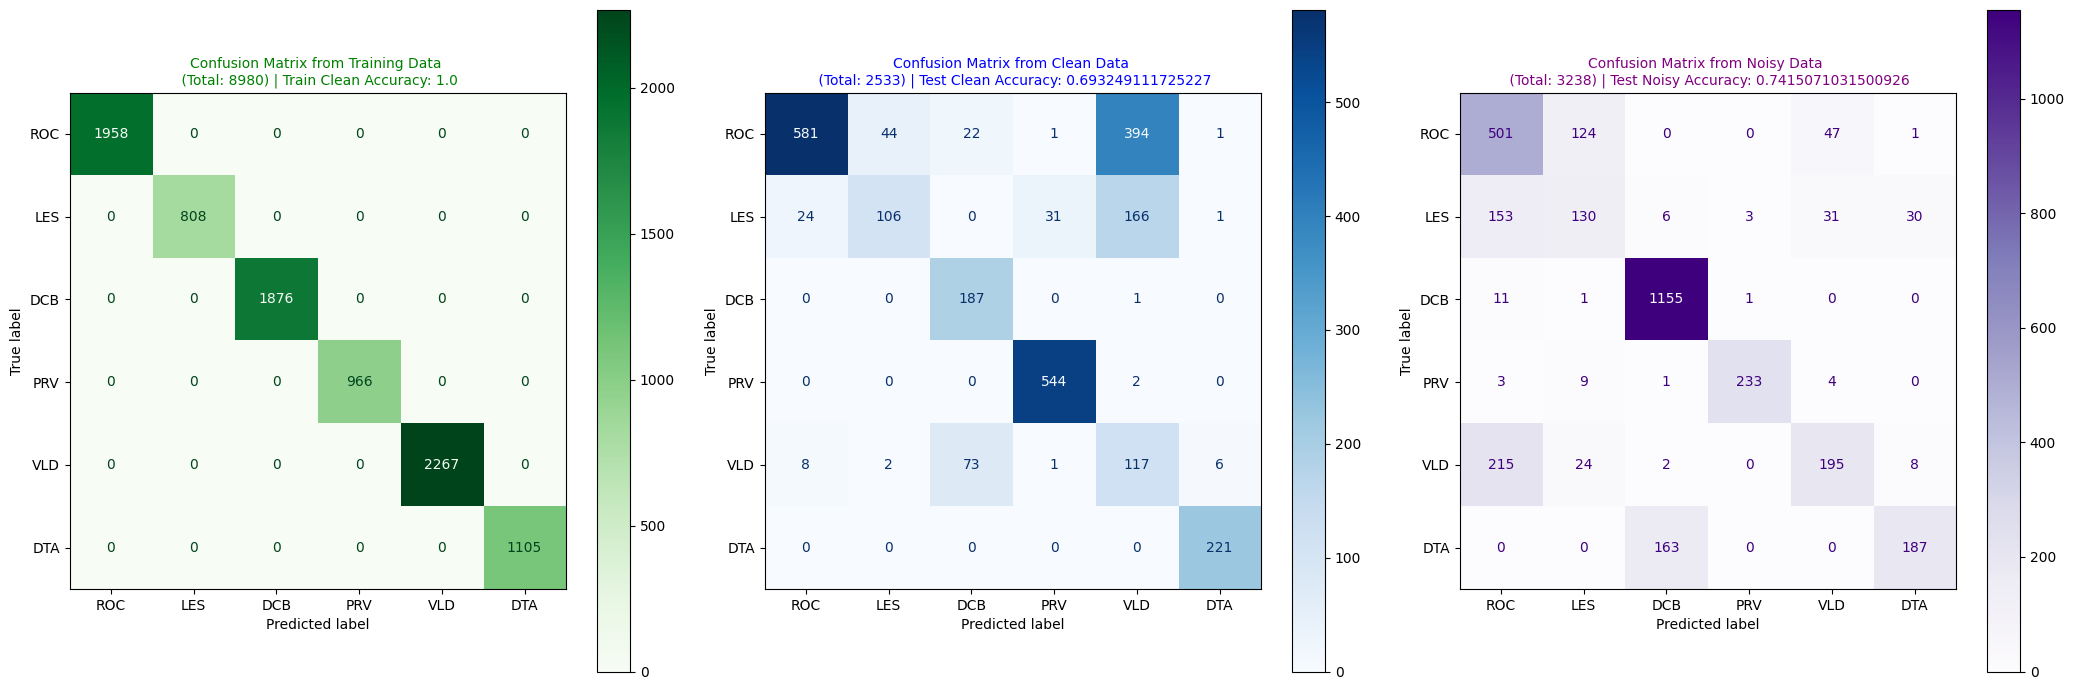

 94%|█████████▍| 15/16 [14:54<02:20, 140.86s/it]

Index: 15
Combination of Algorithm: ComParE + PNCC + PLP + Wav2Vec2 + LPC_26 + MEL

Shape of Train DataFrame: (8980, 9104)
Shape of Test Clean DataFrame: (2533, 9104)
Shape of Test Noisy DataFrame: (3238, 9104)

Accuracy Results:
--------------------
Train Clean Acc = 1.0
Test Clean Acc = 0.696012633241216
Test Noisy Acc = 0.7748610253242743

**************************************************



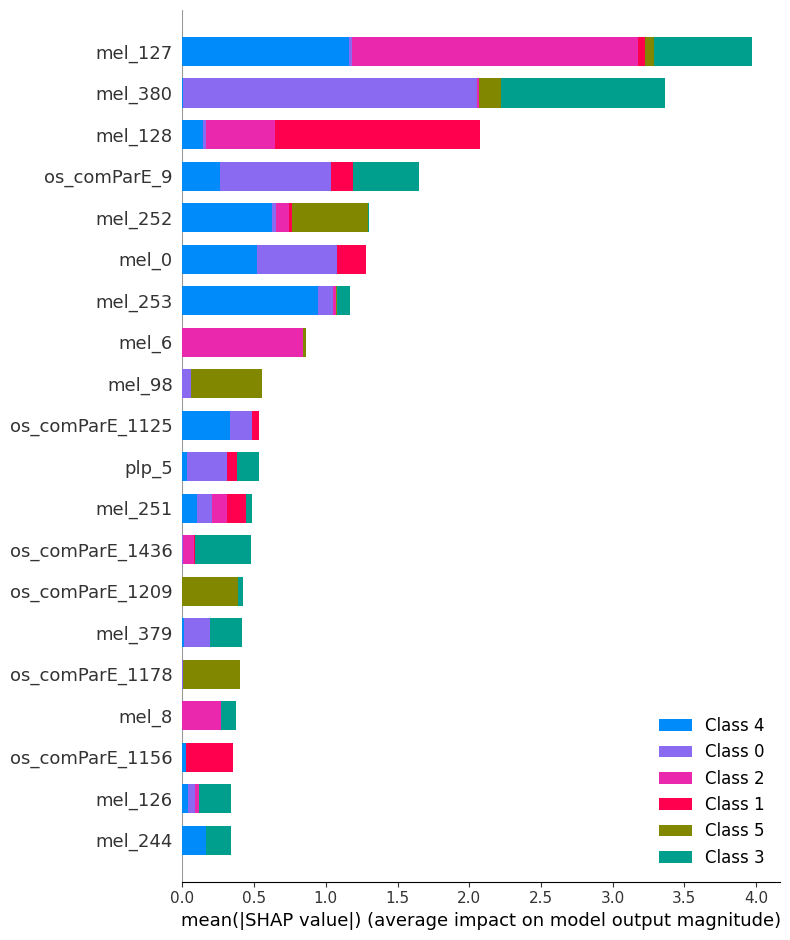

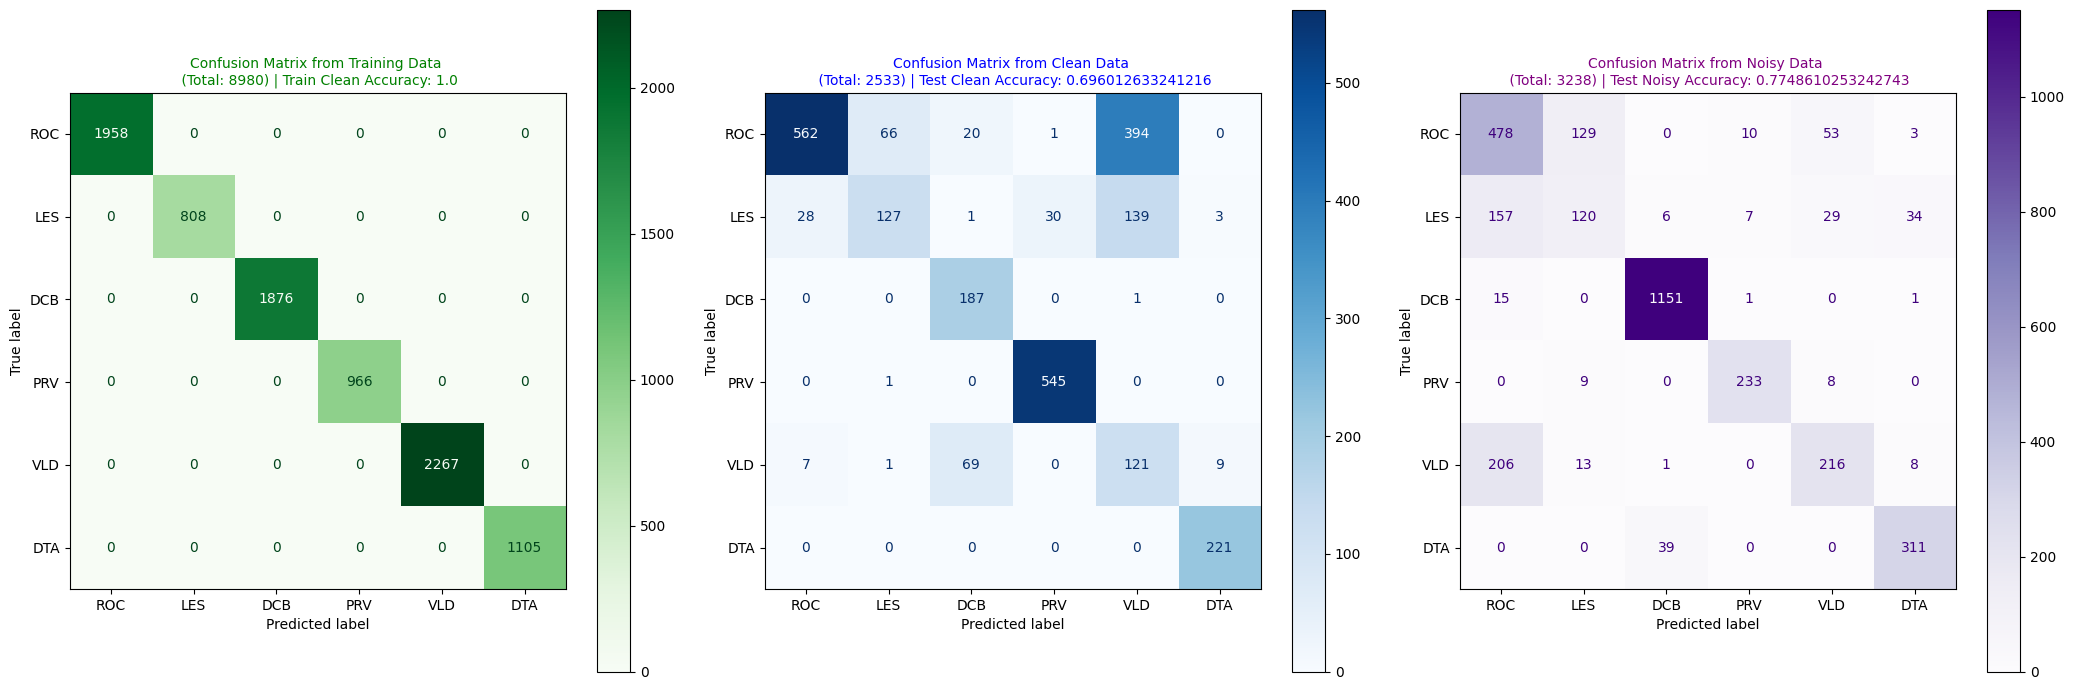

100%|██████████| 16/16 [17:48<00:00, 66.76s/it] 


In [558]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from tqdm import tqdm

# Custom transformer to concatenate DataFrames
class DataFrameConcat(BaseEstimator, TransformerMixin):
    def __init__(self, dataframes):
        self.dataframes = dataframes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        concatenated_df = pd.concat(self.dataframes, axis=1)
        # print(f"Shape of consolidated DataFrame: {concatenated_df.shape}")
        return concatenated_df.to_numpy()

n_dataframes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for n_frame in tqdm(n_dataframes):
    print("Index:", n_frame)
    print("Combination of Algorithm:", dataframes_combination[n_frame])

    train_dataframe = train_dataframes[n_frame]

    # Define the pipeline
    pipeline = Pipeline([
        ('feature_union', DataFrameConcat(train_dataframe)),
        ('classifier', xgb.XGBClassifier())
    ])

    # Convert labels to NumPy arrays
    y_train = np.array(train_label)  # Replace with your actual labels

    # Fit the model
    pipeline.fit(None, y_train)

    # Evaluate the model
    train_clean_accuracy = pipeline.score(None, y_train)


    # Access the classifier from the pipeline 
    xgb_model = pipeline.named_steps['classifier'] 
    
    # # Now you can use xgb_model in subsequent sections 
    # print("XGBoost Model:", xgb_model)

    test_clean_dataframe = test_clean_dataframes[n_frame]

    # Define the test clean pipeline
    test_clean_pipeline = Pipeline([
        ('feature_union', DataFrameConcat(test_clean_dataframe)),
        ('classifier', pipeline.named_steps['classifier'])
    ])

    # Convert test labels to NumPy arrays
    y_test_clean = np.array(test_clean_label)  # Replace with your actual test clean labels

    # Evaluate the model on test clean data
    test_clean_accuracy = test_clean_pipeline.score(None, y_test_clean)

    test_noisy_dataframe = test_noisy_dataframes[n_frame]

    # Define the test clean pipeline
    test_clean_pipeline = Pipeline([
        ('feature_union', DataFrameConcat(test_noisy_dataframe)),
        ('classifier', pipeline.named_steps['classifier'])
    ])

    # Convert test labels to NumPy arrays
    y_test_noisy = np.array(test_noisy_label)  # Replace with your actual test noisy labels

    # Evaluate the model on test noisy data
    test_noisy_accuracy = test_clean_pipeline.score(None, y_test_noisy)

    print("")
    # Print the shape of consolidated DataFrames at the end of each loop
    
    train_feat_df = pd.concat(train_dataframe, axis=1)
    test_clean_feat_df = pd.concat(test_clean_dataframe, axis=1)
    test_noisy_feat_df = pd.concat(test_noisy_dataframe, axis=1)

    print(f"Shape of Train DataFrame: {train_feat_df.shape}")
    print(f"Shape of Test Clean DataFrame: {test_clean_feat_df.shape}")
    print(f"Shape of Test Noisy DataFrame: {test_noisy_feat_df.shape}")
    print("")

    print("Accuracy Results:")
    print(20 * "-")
    print("Train Clean Acc =", train_clean_accuracy)
    print("Test Clean Acc =", test_clean_accuracy)
    print("Test Noisy Acc =", test_noisy_accuracy) 
    print("")   
    print(50 * "*")
    print("")

    # print ("********* << Interpreting Results and Explainability >> ************")
    # print ("To see the impact different features have on the model, we create a plot of the feature importances. \n The features are listed top to bottom in order of how important they were to the decision.")
    # print("")

    import shap

    # model = xgboost.XGBClassifier()
    # model.fit(train_feat_df,y_train)

    # Explain the model's predictions using SHAP by computing SHAP values
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer.shap_values(train_feat_df)

    #Convert the shap values for each class to a single list
    shap_as_list=[]
    for i in range(6):
        shap_as_list.append(shap_values[:,:,i])

    # Plot the SHAP values
    shap.summary_plot(shap_as_list, train_feat_df, plot_type="bar")


    # print("")
    # print ("********* << And we can see a confusion matrix of the mispredictions >> ************")
    # print("")

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Confusion matrix display labels
    labels = ['ROC', 'LES', 'DCB', 'PRV', 'VLD', 'DTA']

    # Compute confusion matrices
    confusion_matrix_train = confusion_matrix(y_train, xgb_model.predict(train_feat_df))
    confusion_matrix_clean = confusion_matrix(y_test_clean, xgb_model.predict(test_clean_feat_df))
    confusion_matrix_noisy = confusion_matrix(y_test_noisy, xgb_model.predict(test_noisy_feat_df))

    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))  # Adjusted figsize for better spacing

    # Plot the first confusion matrix with display labels
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train, display_labels=labels)
    cm_display_train.plot(ax=axes[0], cmap="Greens", colorbar=True)
    axes[0].set_title(f'Confusion Matrix from Training Data \n (Total: {len(y_train)}) | Train Clean Accuracy: {train_clean_accuracy}', fontsize=10, color='green')
    # axes[0].set_xlabel('Predicted', fontsize=12)
    # axes[0].set_ylabel('Actual', fontsize=12)

    # Plot the second confusion matrix with display labels
    cm_display_clean = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_clean, display_labels=labels)
    cm_display_clean.plot(ax=axes[1], cmap="Blues", colorbar=True)
    axes[1].set_title(f'Confusion Matrix from Clean Data \n (Total: {len(y_test_clean)}) | Test Clean Accuracy: {test_clean_accuracy}', fontsize=10, color='blue')
    # axes[1].set_xlabel('Predicted', fontsize=12)
    # axes[1].set_ylabel('Actual', fontsize=12)

    # Plot the third confusion matrix with display labels
    cm_display_noisy = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_noisy, display_labels=labels)
    cm_display_noisy.plot(ax=axes[2], cmap="Purples", colorbar=True)
    axes[2].set_title(f'Confusion Matrix from Noisy Data \n (Total: {len(y_test_noisy)}) | Test Noisy Accuracy: {test_noisy_accuracy}', fontsize=10, color='purple')
    # axes[2].set_xlabel('Predicted', fontsize=12)
    # axes[2].set_ylabel('Actual', fontsize=12)

    # Adjust layout to ensure the titles and labels are clearly visible
    plt.tight_layout()

    # Show plot
    plt.show()
